## initialization

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_style('darkgrid')


In [3]:
# loading dataset 

pd.set_option("display.max_columns", None)
data = pd.read_csv("Airline_Delay_Cause.csv")
data.drop(['airport_name','carrier_name'], axis=1,inplace=True)
# data.info()

# display(data.describe())
# display(data)

# Transformation of data

In [4]:
# convert delay and count cols to average per flight 

dataNormalized = data.copy()
delay_cols = data.loc[:,'arr_del15':'late_aircraft_delay'] 
delay_cols = delay_cols.div(data['arr_flights'], axis=0)   # dividing by arrival flights 
dataNormalized.loc[:,'arr_del15':'late_aircraft_delay'] = delay_cols

dataNormalized.describe()

# Large jump between 75% qunatile and max suggests there are outliers

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,179338.000000,179338.000000,178997.000000,178747.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000
mean,2019.480082,6.485725,327.816969,0.180415,0.066317,0.007903,0.047818,0.000437,0.057690,0.025731,0.002886,11.837256,4.537144,0.868504,2.083489,0.020465,4.327623
std,2.410204,3.463516,931.001446,0.114585,0.061925,0.019375,0.053283,0.003303,0.056879,0.071887,0.013229,15.327833,11.403001,5.524817,3.240477,0.231514,5.820135
min,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.000000,3.000000,41.000000,0.105263,0.032083,0.000000,0.013539,0.000000,0.017857,0.000000,0.000000,5.137931,1.516129,0.000000,0.460000,0.000000,0.836957
50%,2020.000000,6.000000,89.000000,0.166667,0.055672,0.001250,0.036282,0.000000,0.047419,0.003953,0.000000,9.516129,3.141700,0.068826,1.325397,0.000000,2.981618
75%,2022.000000,9.000000,218.000000,0.238018,0.086944,0.009873,0.065893,0.000000,0.082876,0.024752,0.000432,15.518519,5.576923,0.724138,2.659774,0.000000,5.924731
max,2023.000000,12.000000,21977.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,3174.000000,3166.000000,1244.000000,403.000000,43.000000,418.000000


<Axes: xlabel='arr_flights', ylabel='arr_delay'>

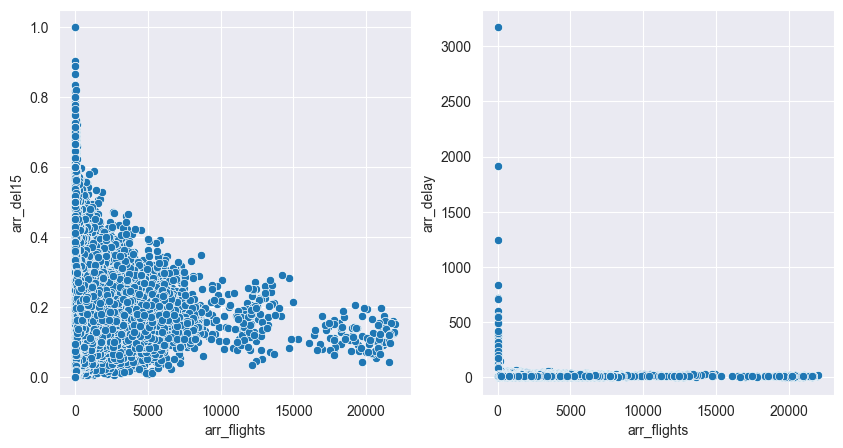

In [4]:
# plotting arrival flights vs delay and del15 to find outliers

_,axs = plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(data=dataNormalized,x='arr_flights',y='arr_del15',ax=axs[0])
sns.scatterplot(data=dataNormalized,x='arr_flights',y='arr_delay',ax=axs[1])

# outliers exists for lower number of arrival flights 

percent of data points with arrival flights less than or equal to 10 :6.715252762939254


Text(0.5, 1.0, 'Without low arrival flights')

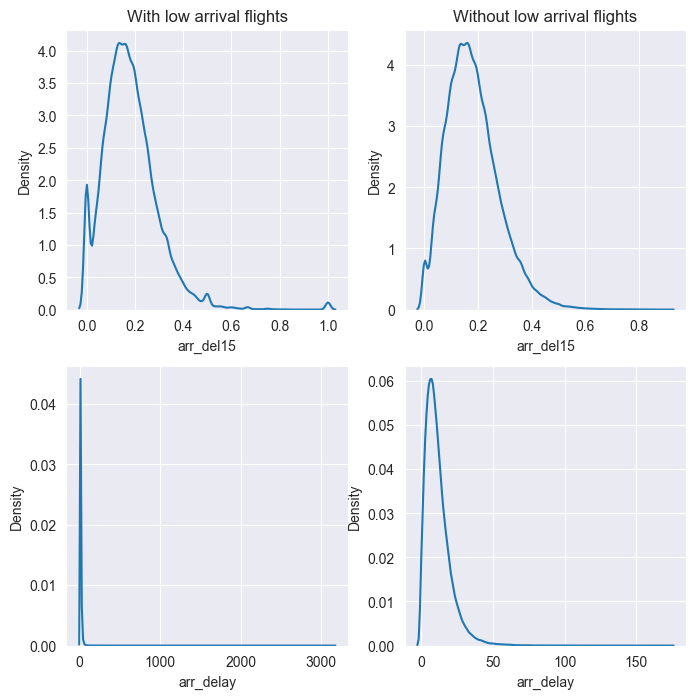

In [5]:
# displaying data with and without datapoints with lower number of arrival flights 

cutoff = 10 
print (f"percent of data points with arrival flights less than or equal to {cutoff} :{sum(dataNormalized['arr_flights']<=cutoff)/len(dataNormalized)*100}")

# removing datapoints with arrival flights lower than cutoff
data_low_Arr_droped = dataNormalized.iloc[[i for i,x in enumerate(dataNormalized['arr_flights'] > cutoff) if x],:]

_,axs = plt.subplots(2,2,figsize=(8,8))
sns.kdeplot(data=dataNormalized, x = 'arr_del15',ax=axs[0,0])
sns.kdeplot(data=dataNormalized, x = 'arr_delay',ax=axs[1,0])
axs[0,0].set_title('With low arrival flights')

sns.kdeplot(data=data_low_Arr_droped, x = 'arr_del15',ax=axs[0,1])
sns.kdeplot(data=data_low_Arr_droped, x = 'arr_delay',ax=axs[1,1])
axs[0,1].set_title('Without low arrival flights')


For low number of arrival flights statistical fluctuations are stronger. 

For example data point with very low true average flights delayed may have 0.5 or 1 arr_del15 if it have 2 arr_flights depending on change. This is apparent by reduction of peaks and bumps at 0, 0.33, 0.5, 0.67 and 1 in arr_del15 kde plot. Similarly, while, large delays are less likely, it is possible that data points with low arrival flights may have all of the flights with large delays due to chance.

Since we are concerned with average fractions of flights delayed (and avg delay time), we have less confidence when arrival flights are less. So we will replace them (along with NA value) with a resonable guess like median values of the carries.

In [6]:
# finding the mean values of counts and delays for each carrier

carriers = dataNormalized.carrier.unique()
mean_vals = pd.DataFrame()

for car in carriers:
    mean_vals[car] = data_low_Arr_droped[data_low_Arr_droped.carrier == car].loc[:,'arr_del15':'late_aircraft_delay'].describe().loc['mean']

mean_vals

,9E,AA,OH,OO,WN,AS,DL,PT,QX,UA,YV,B6,F9,G4,G7,HA,MQ,YX,ZW,C5,NK,EM,EV,AX,CP,KS,9K,VX,US
arr_del15,0.131145,0.204669,0.177065,0.163440,0.194743,0.154067,0.133123,0.148139,0.139520,0.193913,0.193688,0.240163,0.227451,0.205797,0.189533,0.200893,0.170122,0.148912,0.180851,0.228384,0.206411,0.129920,0.188897,0.257588,0.168523,0.315089,0.082905,0.211504,0.198172
carrier_ct,0.046398,0.077666,0.055013,0.073568,0.072772,0.045888,0.059532,0.036969,0.049766,0.067107,0.082311,0.103421,0.076183,0.063578,0.061106,0.158450,0.044826,0.039709,0.053324,0.086650,0.056137,0.036647,0.069057,0.081266,0.054195,0.103538,0.045177,0.048628,0.077575
weather_ct,0.005493,0.007504,0.009750,0.011653,0.003418,0.004386,0.007184,0.009301,0.005055,0.007922,0.011640,0.005660,0.003992,0.013006,0.005367,0.002348,0.013133,0.005076,0.007189,0.009056,0.006505,0.002175,0.003780,0.008305,0.002965,0.021929,0.000391,0.016373,0.003345
nas_ct,0.039295,0.050317,0.048773,0.028325,0.030338,0.061995,0.034890,0.047531,0.040618,0.049142,0.040732,0.062342,0.071869,0.054188,0.054258,0.002021,0.057192,0.056238,0.050478,0.062028,0.094053,0.013757,0.053876,0.061128,0.040095,0.110837,0.018512,0.064870,0.073957
security_ct,0.000122,0.000557,0.000647,0.000279,0.000488,0.000811,0.000162,0.000254,0.000389,0.000039,0.000394,0.001115,0.000000,0.001257,0.000013,0.002110,0.000385,0.000246,0.000018,0.000068,0.002065,0.000288,0.000000,0.000032,0.000222,0.000000,0.000000,0.000919,0.001208
late_aircraft_ct,0.039743,0.068567,0.062797,0.049600,0.087727,0.040988,0.031357,0.054087,0.043694,0.069704,0.058611,0.067623,0.075407,0.072905,0.068788,0.035967,0.054569,0.047646,0.069834,0.070581,0.047482,0.077052,0.062186,0.106855,0.070258,0.078783,0.018843,0.080717,0.042087
arr_cancelled,0.021122,0.020721,0.030523,0.022218,0.022014,0.014731,0.010739,0.036610,0.023336,0.017410,0.032855,0.024813,0.022838,0.039657,0.030373,0.006544,0.031613,0.032250,0.033691,0.035812,0.023451,0.052500,0.031397,0.044593,0.021813,0.154147,0.000952,0.010870,0.013311
arr_diverted,0.002290,0.002303,0.002570,0.004287,0.001714,0.004032,0.002165,0.003918,0.003502,0.002258,0.002301,0.003854,0.001488,0.003726,0.002375,0.002560,0.002577,0.002452,0.002386,0.003046,0.001608,0.006597,0.003348,0.003228,0.002391,0.022322,0.001767,0.002139,0.001972
arr_delay,9.145889,13.118612,11.017712,12.016601,9.724614,7.062461,8.313677,9.377543,6.505387,12.905482,15.222086,16.489250,15.055745,13.780135,14.823905,9.030904,9.238828,9.453044,14.022398,18.411002,13.477566,7.694567,12.987172,20.964521,11.435685,17.607485,3.485366,11.329857,9.849903
carrier_delay,3.286502,4.950978,3.308267,5.736665,3.429635,2.499991,3.959796,2.231914,2.455662,4.052401,6.426491,7.232354,4.797853,5.292835,4.716332,6.839081,2.333347,2.797864,3.932887,6.899568,3.691840,2.174335,5.700248,6.259937,4.302486,6.910622,1.876746,2.605545,4.378351


In [7]:
# replacing the low arr_flights and NA data with mean values of their respective carrier 

dataImputed = dataNormalized.copy()
dataImputed.loc[:,'arr_del15':] = dataNormalized.apply(
    lambda row : mean_vals[row['carrier']] if (row['arr_flights'] <= cutoff or row.isna().any()) else row.loc['arr_del15':],
    axis=1
)
dataImputed['arr_flights'] = dataImputed['arr_flights'].fillna(
    dataImputed.groupby('carrier')['arr_flights'].transform('mean')
)


# EDA

Text(0.5, 1.0, 'fraction of delay time')

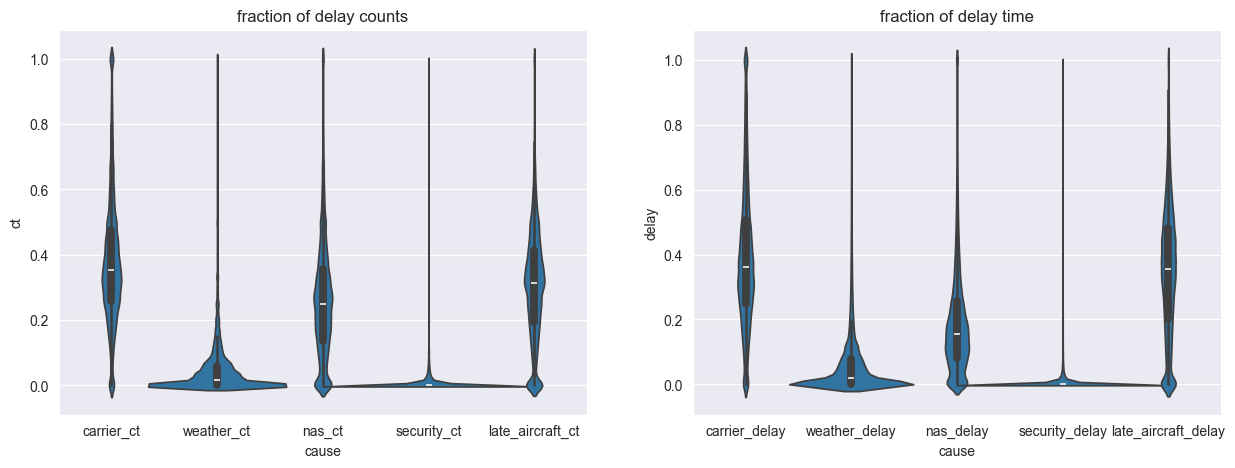

In [ ]:
# displaying the distribution of fractions of delays caused by each cause 

ct_data = dataImputed.loc[:,'carrier_ct':'late_aircraft_ct']
ct_data = ct_data.div(dataImputed['arr_del15'], axis=0)  # division by number of delay to convert to fraction of delays

delay_data = dataImputed.loc[:,'carrier_delay':'late_aircraft_delay']
delay_data = delay_data.div(dataImputed['arr_delay'], axis=0)  # division by delay time to convert to fraction of time delayed

# combining count and delay columns to single column
ct_melted = ct_data.melt(var_name='cause',value_name='ct')
delay_melted = delay_data.melt(var_name='cause',value_name='delay')

_,axs = plt.subplots(1,2,figsize=(15,5))
sns.violinplot(data=ct_melted,x='cause',y='ct',width=2,ax=axs[0])
axs[0].set_title('fraction of delay counts')
sns.violinplot(data=delay_melted,x='cause',y='delay',width=2,ax=axs[1])
axs[1].set_title('fraction of delay time')

<Axes: >

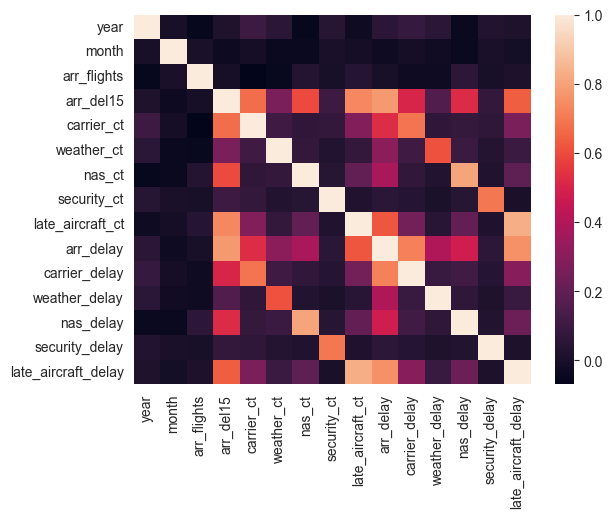

In [67]:
# correlation between labels
sns.heatmap(dataImputed.drop(['carrier','airport'],axis=1).corr())

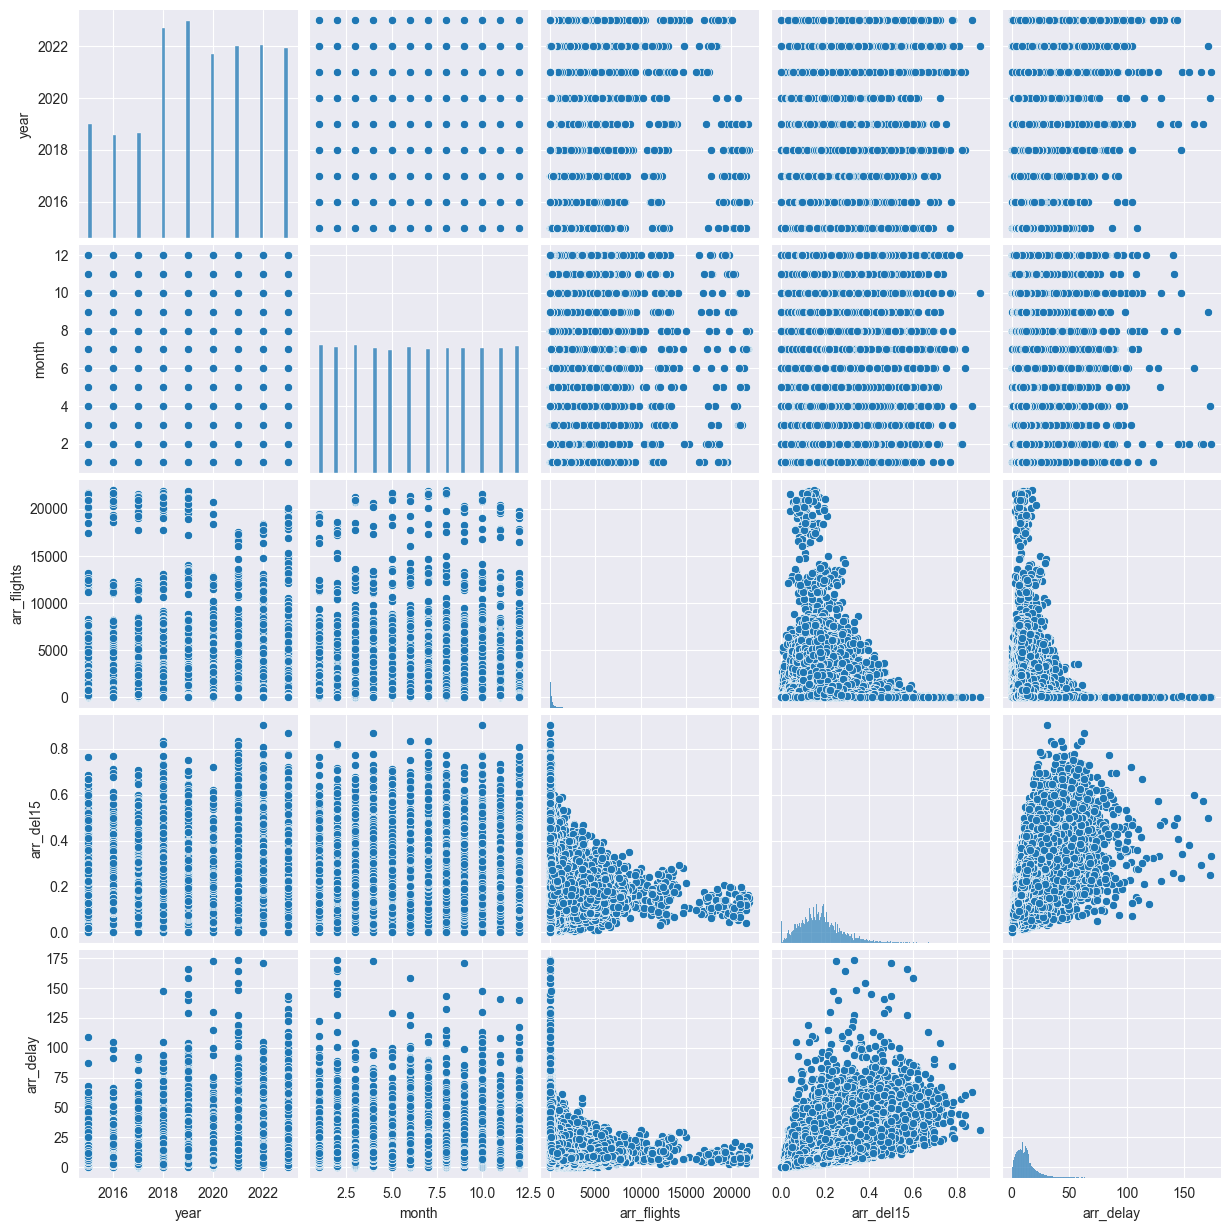

In [ ]:
sns.pairplot(dataImputed.drop(dataImputed.iloc[:,6:11], axis=1).drop(dataImputed.iloc[:,12:],axis=1))

### Variation of labels with features

<Axes: xlabel='carrier', ylabel='arr_delay'>

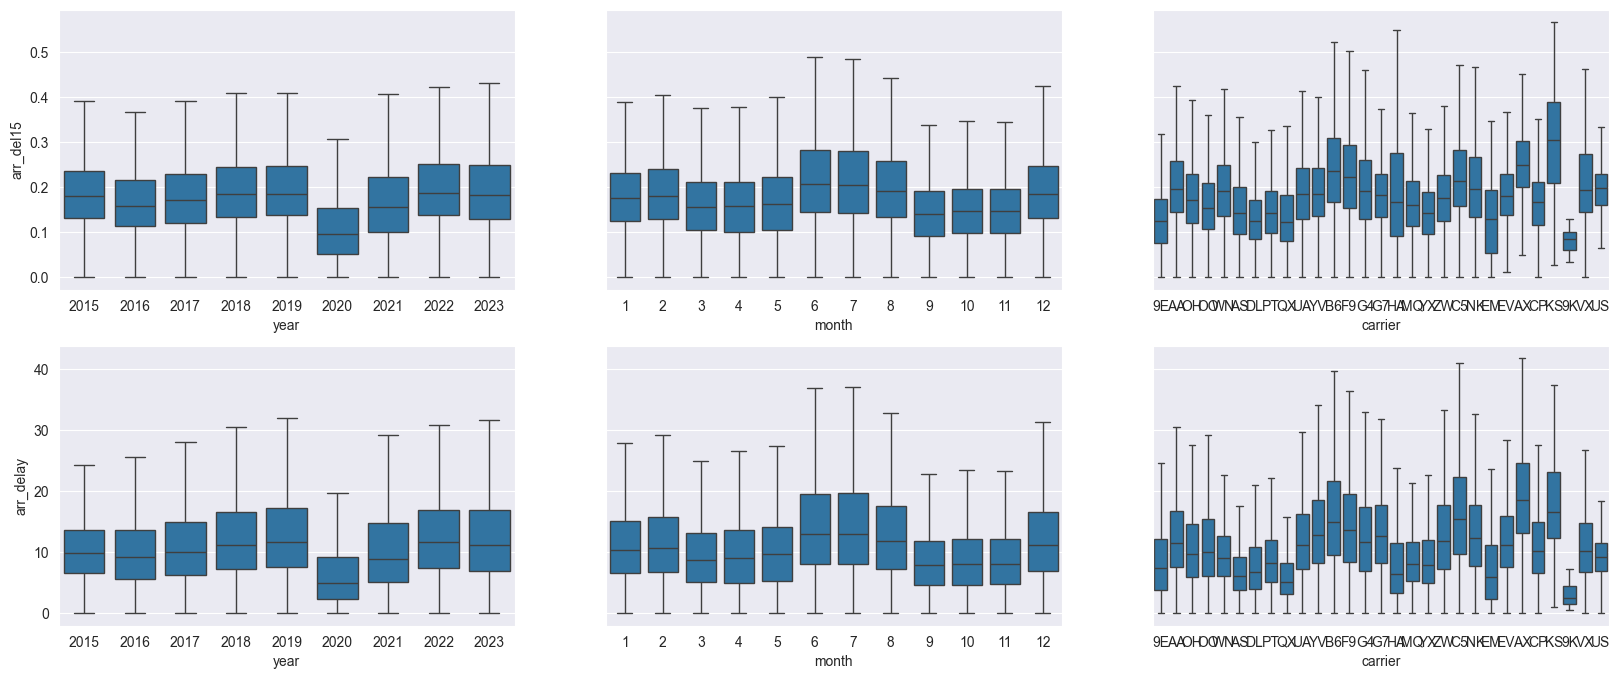

In [ ]:
# variation of arr_del15 and arr_delay
fig, axs = plt.subplots(2,3,figsize=(20,8), sharey='row')
sns.boxplot(data=dataImputed, x='year',y='arr_del15',ax=axs[0,0],showfliers=False)
sns.boxplot(data=dataImputed, x='month',y='arr_del15',ax=axs[0,1],showfliers=False)
sns.boxplot(data=dataImputed, x='carrier',y='arr_del15',ax=axs[0,2],showfliers=False)

sns.boxplot(data=dataImputed, x='year',y='arr_delay',ax=axs[1,0],showfliers=False)
sns.boxplot(data=dataImputed, x='month',y='arr_delay',ax=axs[1,1],showfliers=False)
sns.boxplot(data=dataImputed, x='carrier',y='arr_delay',ax=axs[1,2],showfliers=False)


<Axes: xlabel='carrier', ylabel='carrier_delay'>

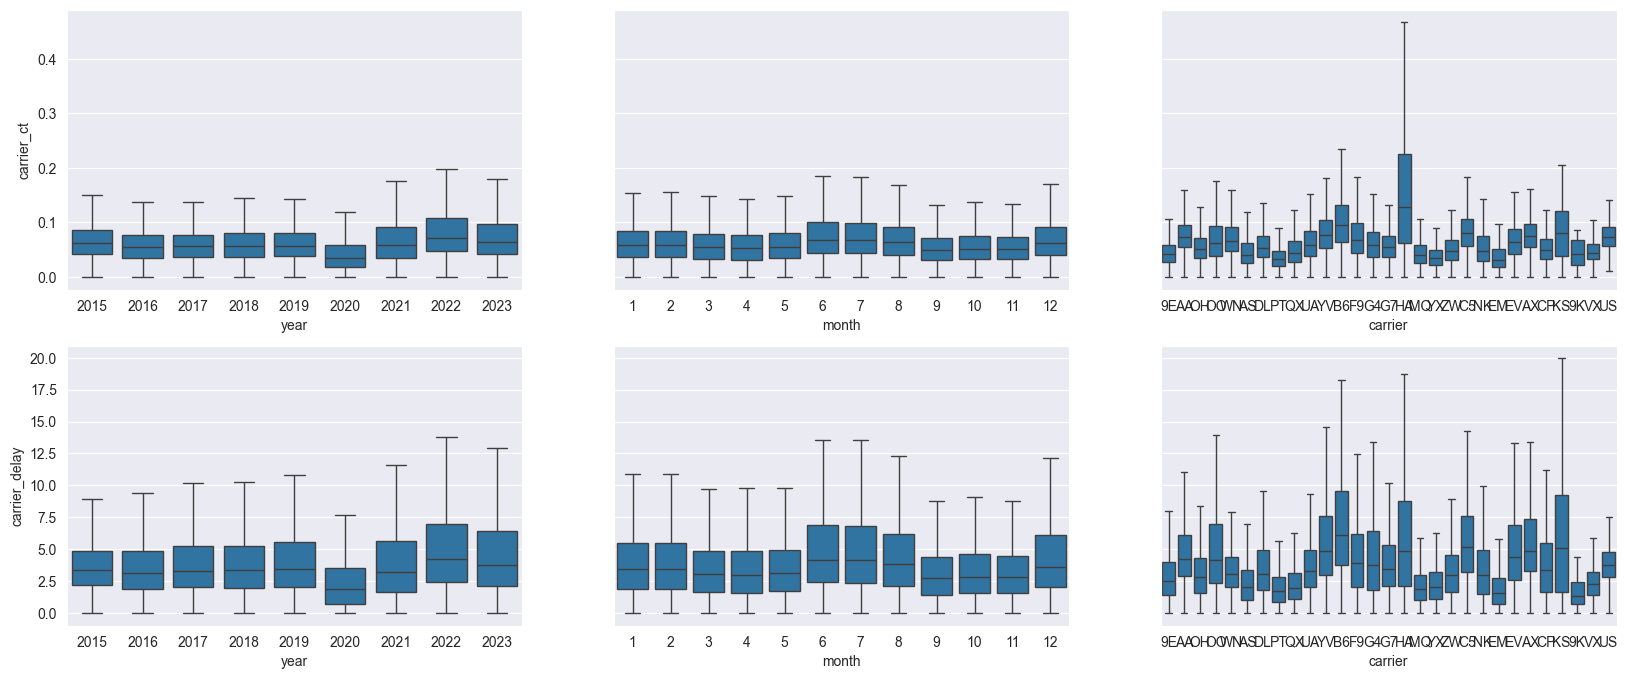

In [ ]:
# variation of carrier_ct and carrier_delay

fig, axs = plt.subplots(2,3,figsize=(20,8),sharey='row')
sns.boxplot(data=dataImputed, x='year',y='carrier_ct',ax=axs[0,0],showfliers=False)
sns.boxplot(data=dataImputed, x='month',y='carrier_ct',ax=axs[0,1],showfliers=False)
sns.boxplot(data=dataImputed, x='carrier',y='carrier_ct',ax=axs[0,2],showfliers=False)

sns.boxplot(data=dataImputed, x='year',y='carrier_delay',ax=axs[1,0],showfliers=False)
sns.boxplot(data=dataImputed, x='month',y='carrier_delay',ax=axs[1,1],showfliers=False)
sns.boxplot(data=dataImputed, x='carrier',y='carrier_delay',ax=axs[1,2],showfliers=False)

<Axes: xlabel='carrier', ylabel='weather_delay'>

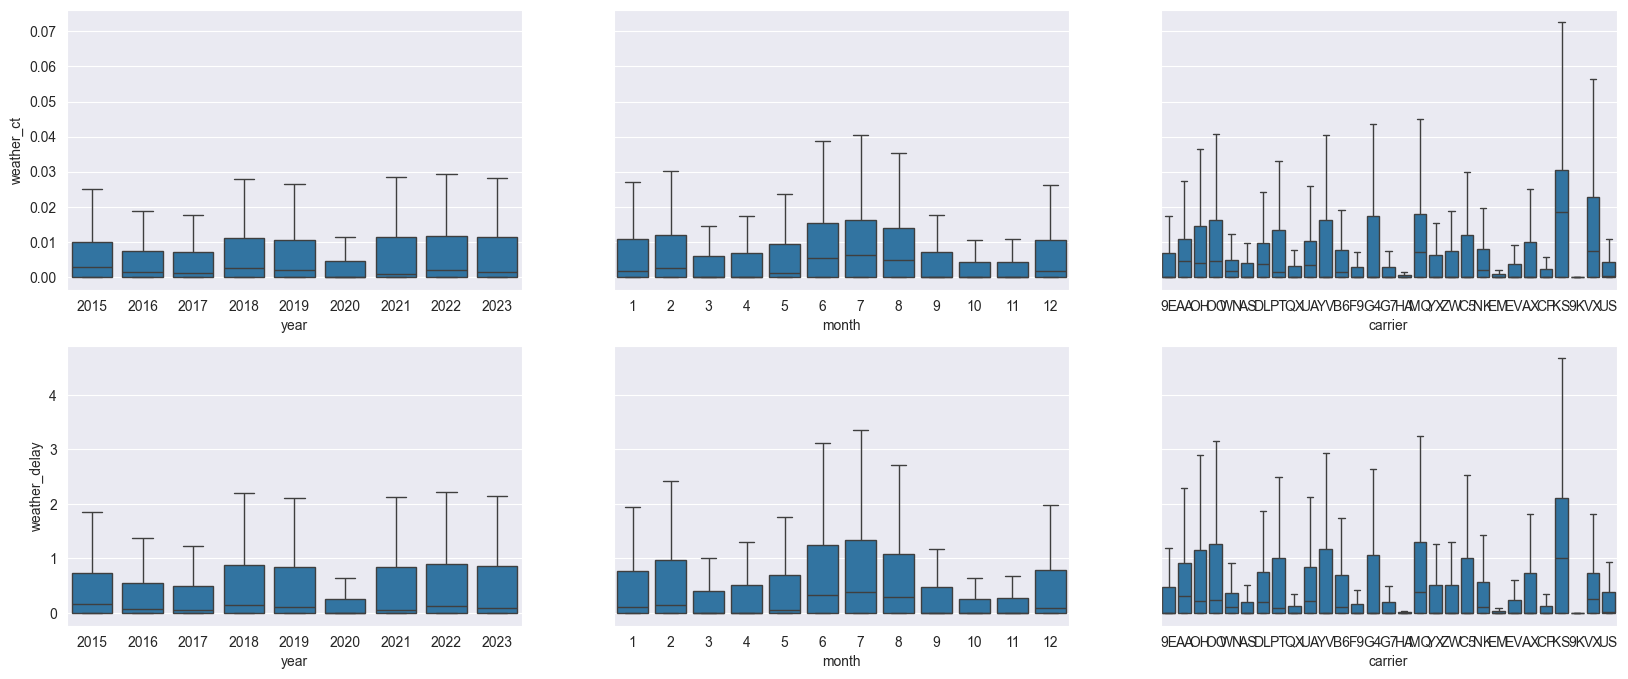

In [ ]:
# variation of weather_ct and weather_delay

fig, axs = plt.subplots(2,3,figsize=(20,8),sharey='row')
sns.boxplot(data=dataImputed, x='year',y='weather_ct',ax=axs[0,0],showfliers=False)
sns.boxplot(data=dataImputed, x='month',y='weather_ct',ax=axs[0,1],showfliers=False)
sns.boxplot(data=dataImputed, x='carrier',y='weather_ct',ax=axs[0,2],showfliers=False)

sns.boxplot(data=dataImputed, x='year',y='weather_delay',ax=axs[1,0],showfliers=False)
sns.boxplot(data=dataImputed, x='month',y='weather_delay',ax=axs[1,1],showfliers=False)
sns.boxplot(data=dataImputed, x='carrier',y='weather_delay',ax=axs[1,2],showfliers=False)

<Axes: xlabel='carrier', ylabel='nas_delay'>

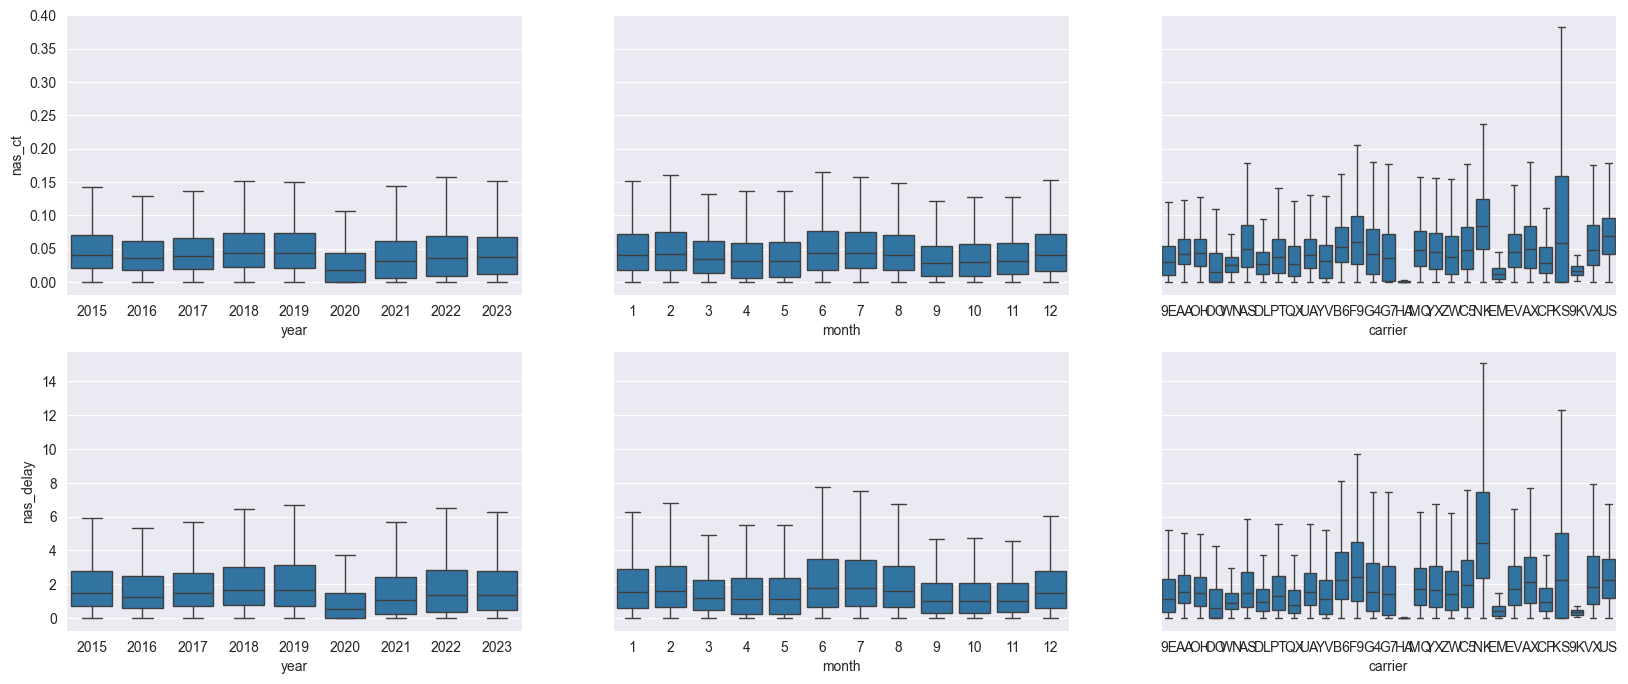

In [ ]:
# variation of nas_ct and nas_delay

fig, axs = plt.subplots(2,3,figsize=(20,8),sharey='row')
sns.boxplot(data=dataImputed, x='year',y='nas_ct',ax=axs[0,0],showfliers=False)
sns.boxplot(data=dataImputed, x='month',y='nas_ct',ax=axs[0,1],showfliers=False)
sns.boxplot(data=dataImputed, x='carrier',y='nas_ct',ax=axs[0,2],showfliers=False)

sns.boxplot(data=dataImputed, x='year',y='nas_delay',ax=axs[1,0],showfliers=False)
sns.boxplot(data=dataImputed, x='month',y='nas_delay',ax=axs[1,1],showfliers=False)
sns.boxplot(data=dataImputed, x='carrier',y='nas_delay',ax=axs[1,2],showfliers=False)

<Axes: xlabel='carrier', ylabel='security_delay'>

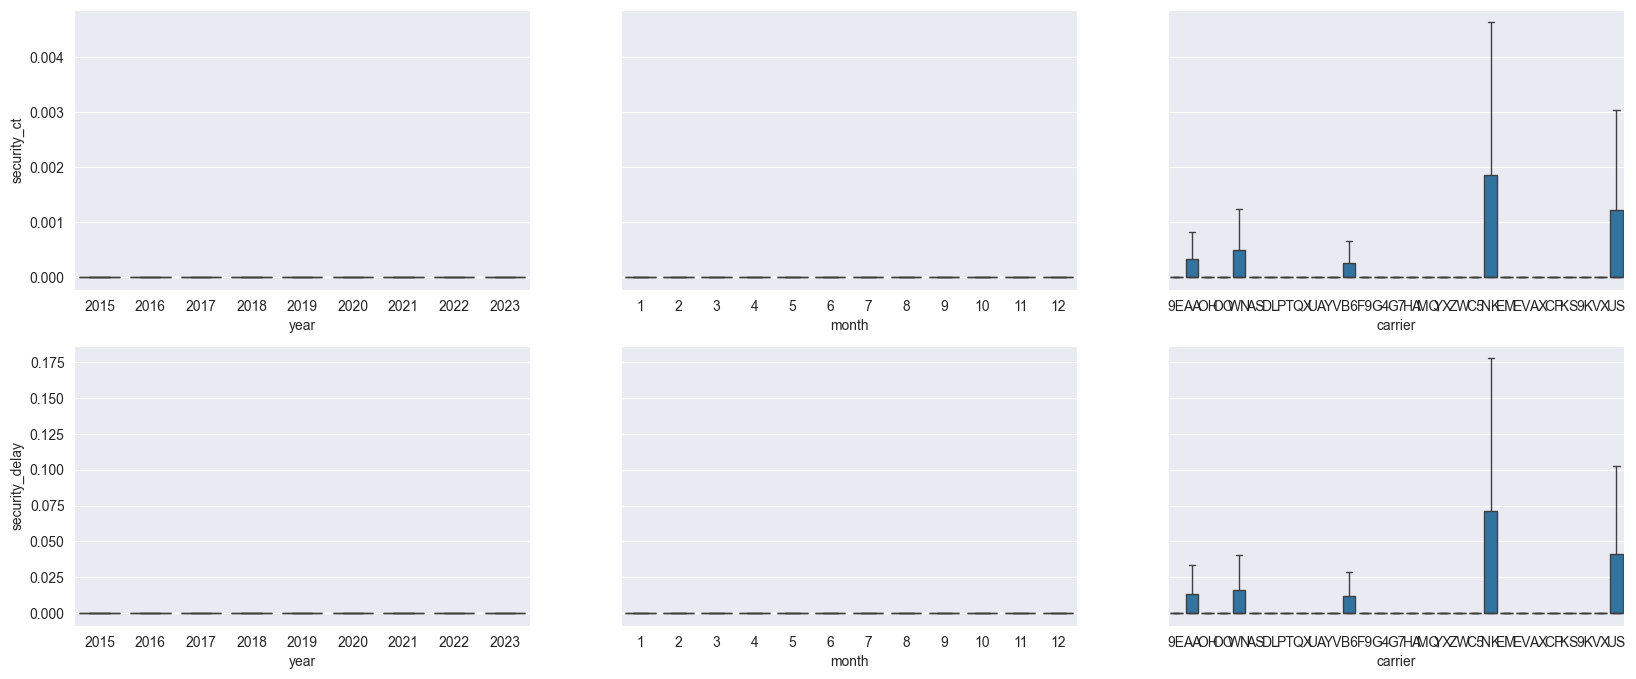

In [ ]:
# variation of security_ct and security_delay

fig, axs = plt.subplots(2,3,figsize=(20,8),sharey='row')
sns.boxplot(data=dataImputed, x='year',y='security_ct',ax=axs[0,0],showfliers=False)
sns.boxplot(data=dataImputed, x='month',y='security_ct',ax=axs[0,1],showfliers=False)
sns.boxplot(data=dataImputed, x='carrier',y='security_ct',ax=axs[0,2],showfliers=False)

sns.boxplot(data=dataImputed, x='year',y='security_delay',ax=axs[1,0],showfliers=False)
sns.boxplot(data=dataImputed, x='month',y='security_delay',ax=axs[1,1],showfliers=False)
sns.boxplot(data=dataImputed, x='carrier',y='security_delay',ax=axs[1,2],showfliers=False)

<Axes: xlabel='carrier', ylabel='late_aircraft_delay'>

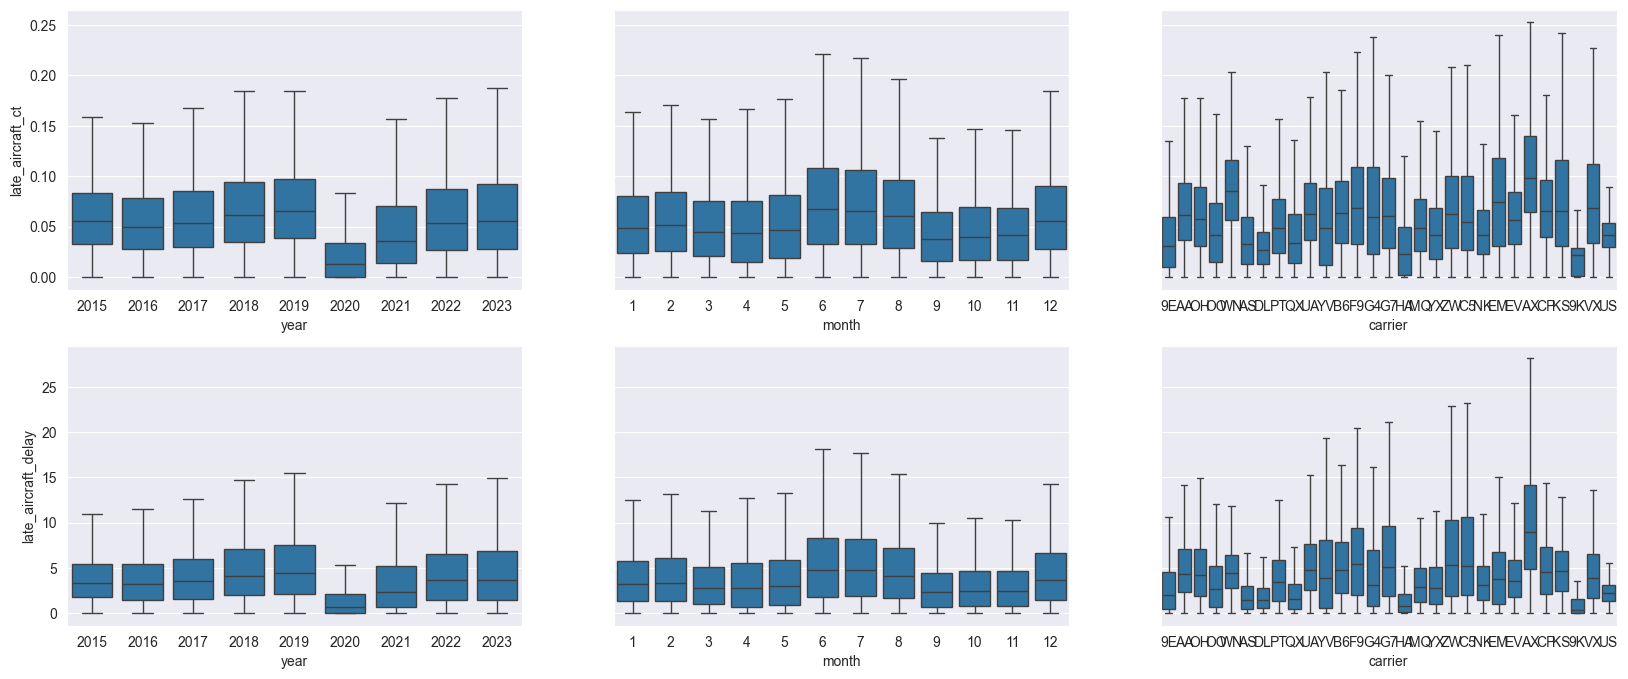

In [ ]:
# variation of late_aircraft_ct and late_aircraft_delay

fig, axs = plt.subplots(2,3,figsize=(20,8),sharey='row')
sns.boxplot(data=dataImputed, x='year',y='late_aircraft_ct',ax=axs[0,0],showfliers=False)
sns.boxplot(data=dataImputed, x='month',y='late_aircraft_ct',ax=axs[0,1],showfliers=False)
sns.boxplot(data=dataImputed, x='carrier',y='late_aircraft_ct',ax=axs[0,2],showfliers=False)

sns.boxplot(data=dataImputed, x='year',y='late_aircraft_delay',ax=axs[1,0],showfliers=False)
sns.boxplot(data=dataImputed, x='month',y='late_aircraft_delay',ax=axs[1,1],showfliers=False)
sns.boxplot(data=dataImputed, x='carrier',y='late_aircraft_delay',ax=axs[1,2],showfliers=False)

<Axes: xlabel='airport', ylabel='arr_delay'>

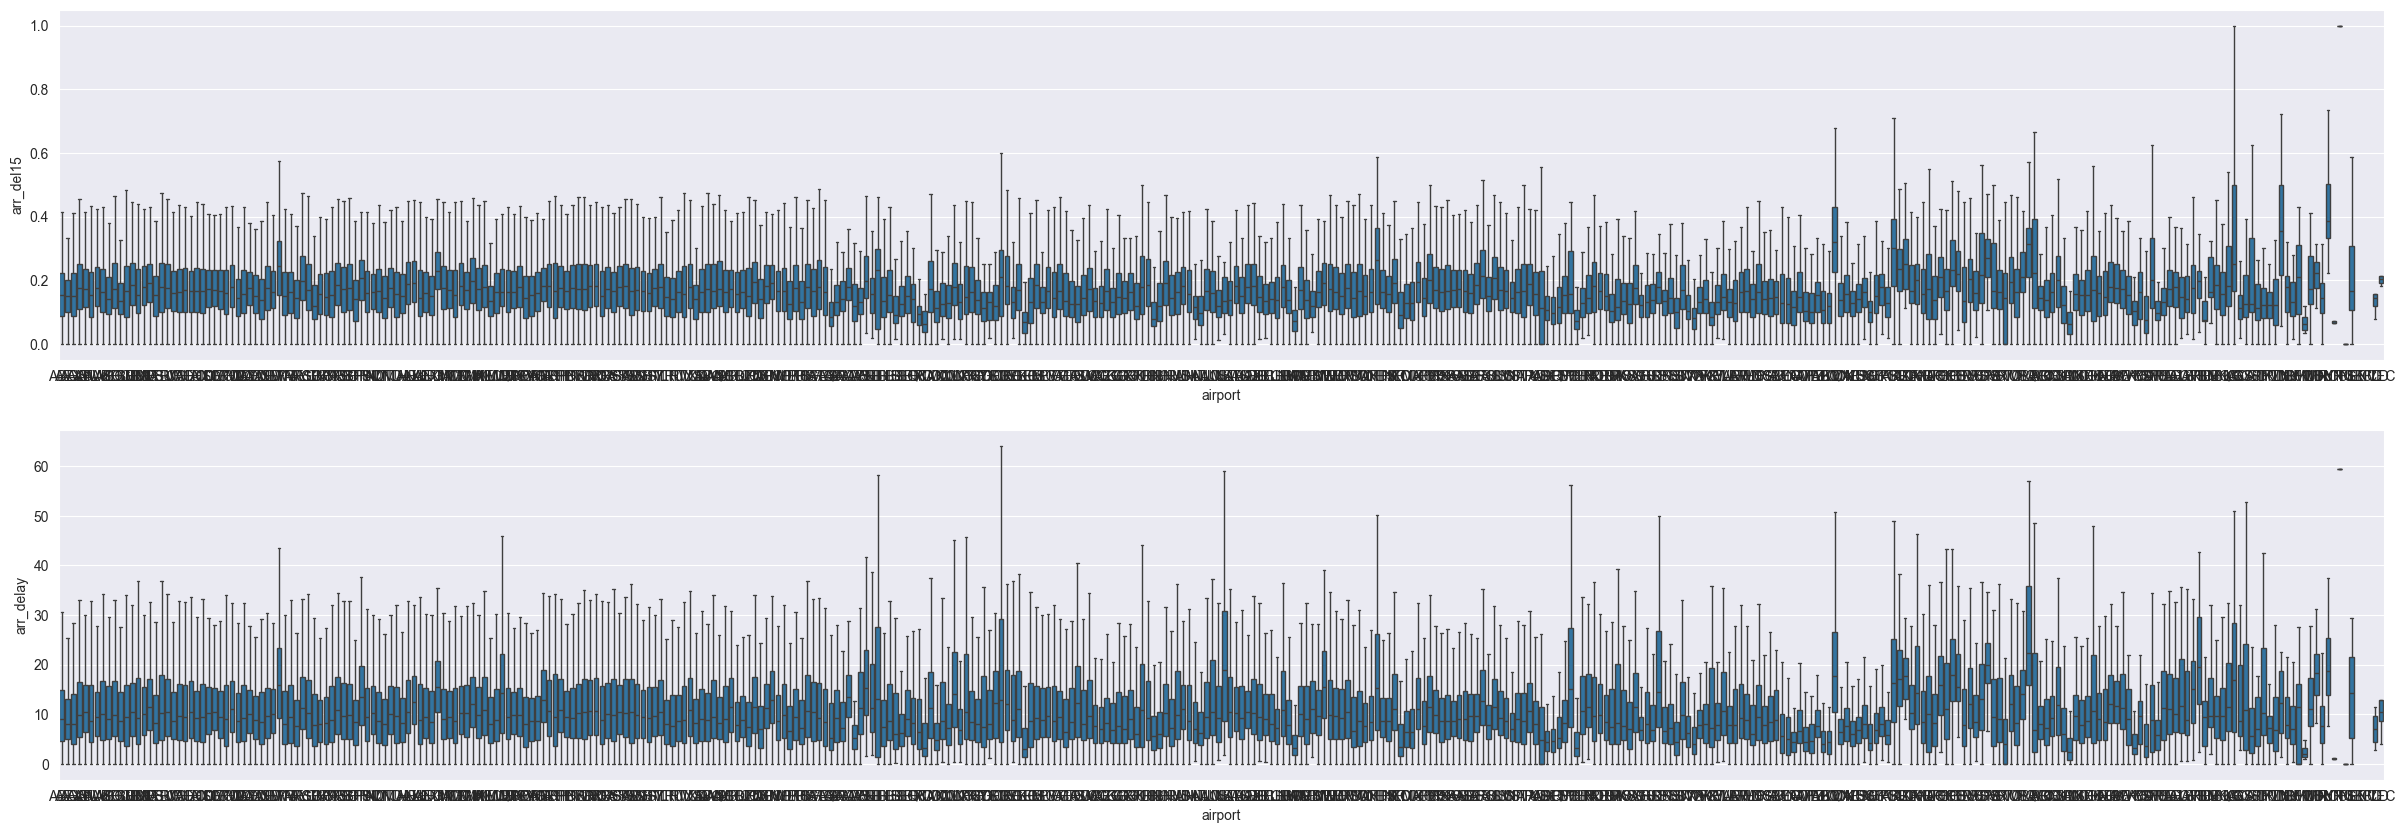

In [ ]:
# variation of arr_del15 and arr_delay with airport 

_,axs = plt.subplots(2,1,figsize=[30,10])
sns.boxplot(data=dataImputed, x='airport',y='arr_del15',showfliers=False,ax=axs[0])
sns.boxplot(data=dataImputed, x='airport',y='arr_delay',showfliers=False,ax=axs[1])


<Axes: xlabel='airport', ylabel='carrier_delay'>

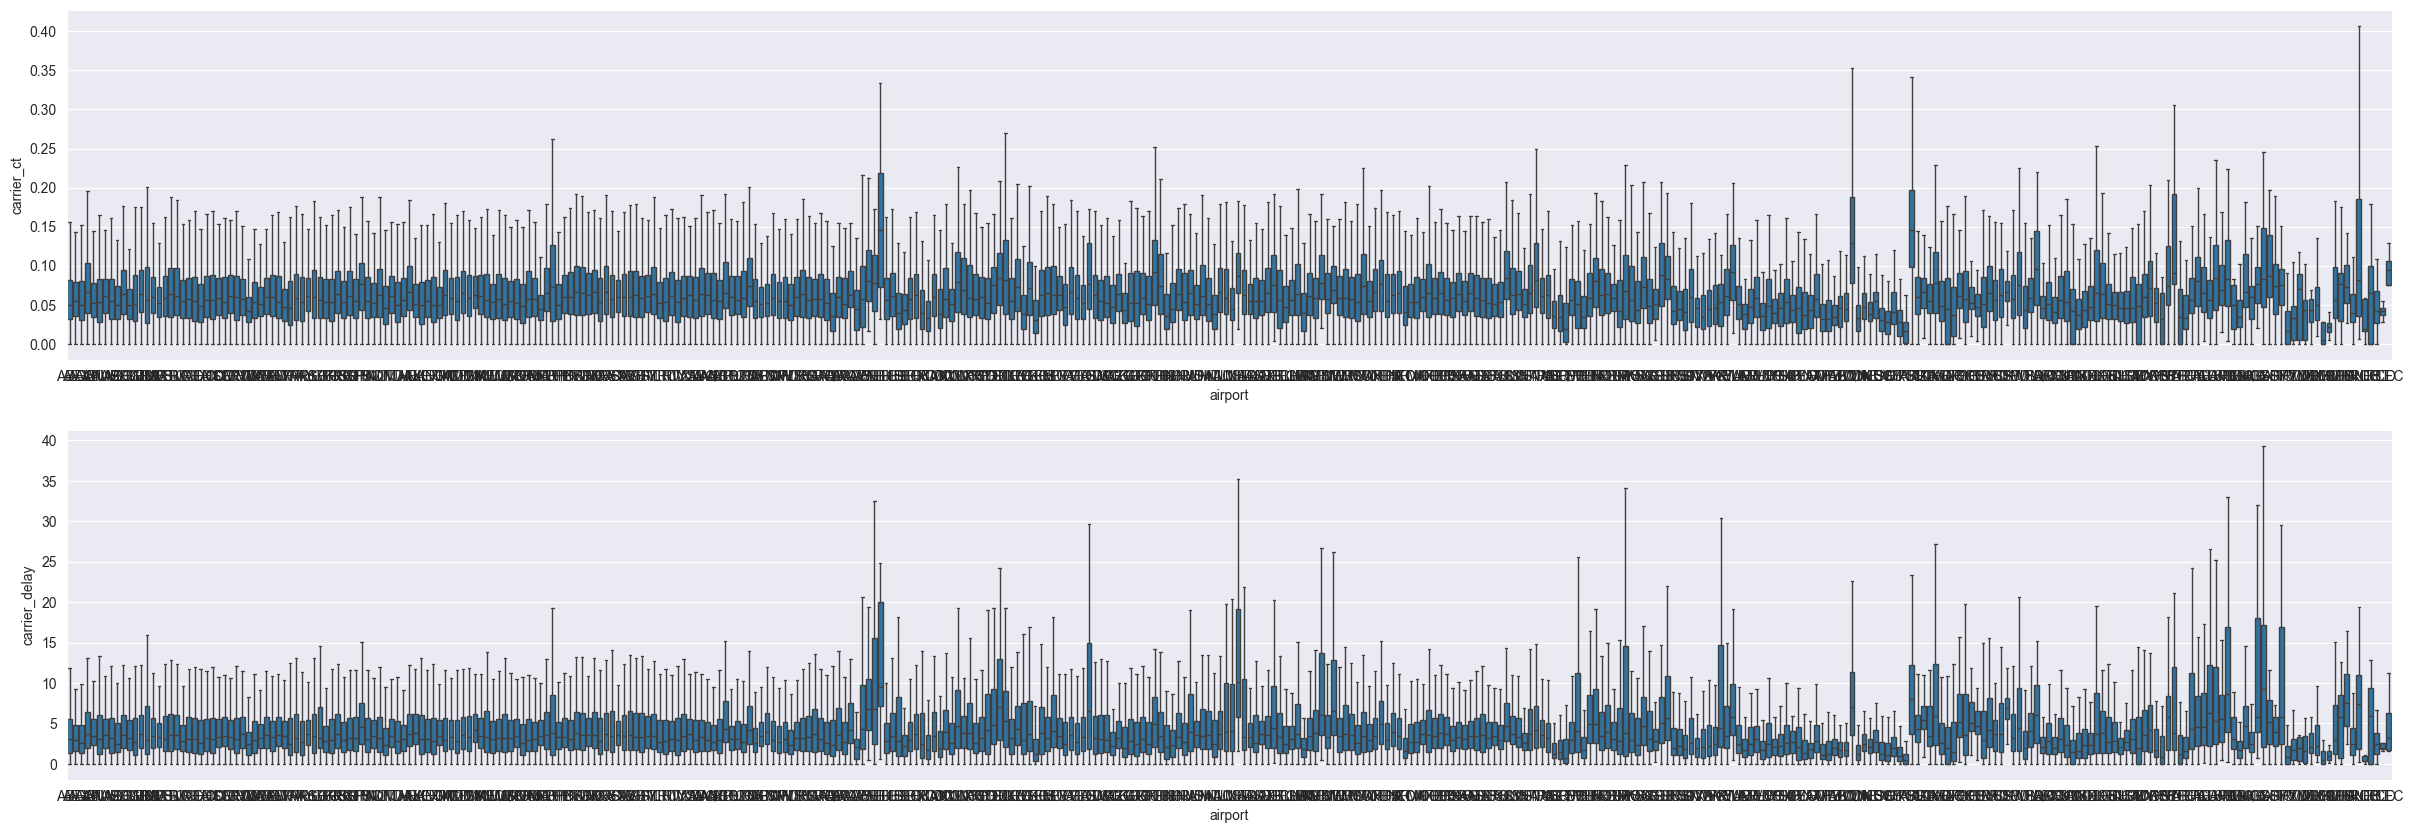

In [ ]:
# variation of carrier delay with airport 

label = 'carrier'
_,axs = plt.subplots(2,1,figsize=[30,10])
sns.boxplot(data=dataImputed, x='airport',y=label+'_ct', ax=axs[0], showfliers=False)
sns.boxplot(data=dataImputed, x='airport',y=label+'_delay', ax=axs[1], showfliers=False)


<Axes: xlabel='airport', ylabel='weather_delay'>

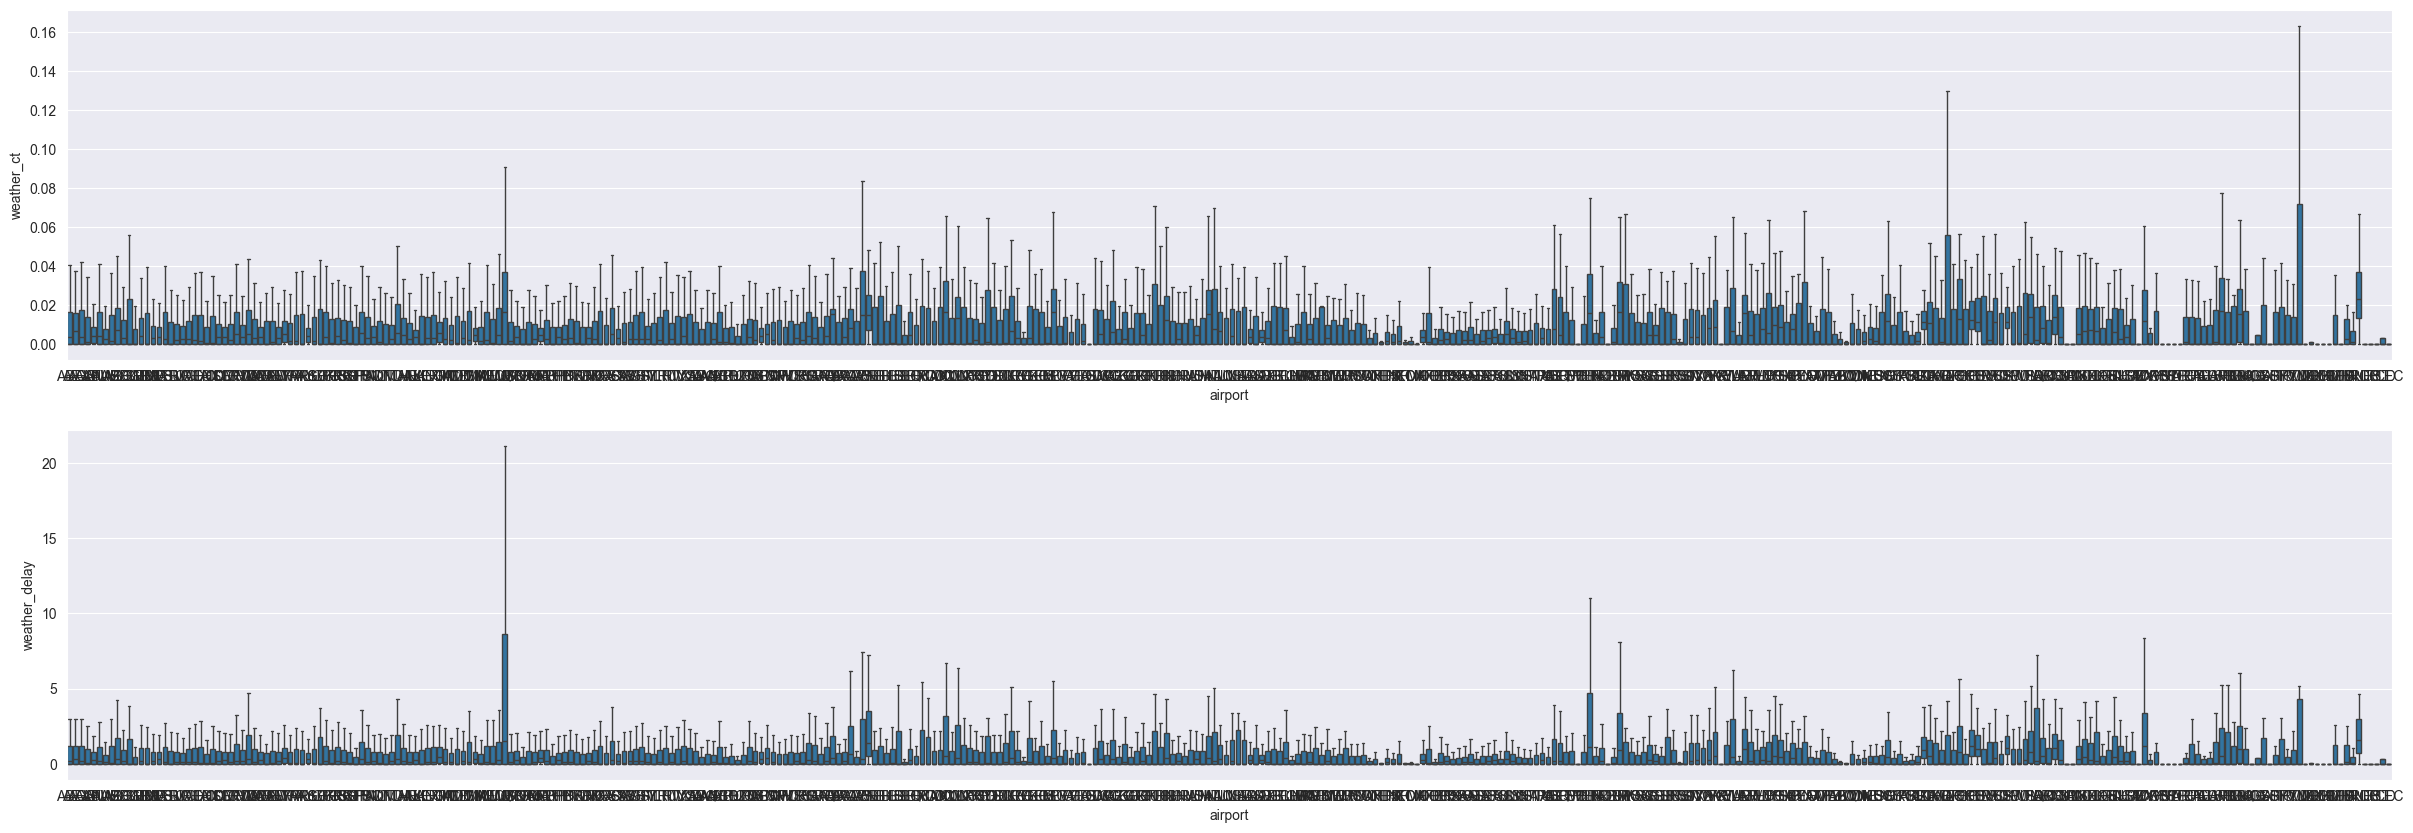

In [ ]:
# variation of weather delay with airport 

label = 'weather'
_,axs = plt.subplots(2,1,figsize=[30,10])
sns.boxplot(data=dataImputed, x='airport',y=label+'_ct', ax=axs[0], showfliers=False)
sns.boxplot(data=dataImputed, x='airport',y=label+'_delay', ax=axs[1], showfliers=False)


<Axes: xlabel='airport', ylabel='nas_delay'>

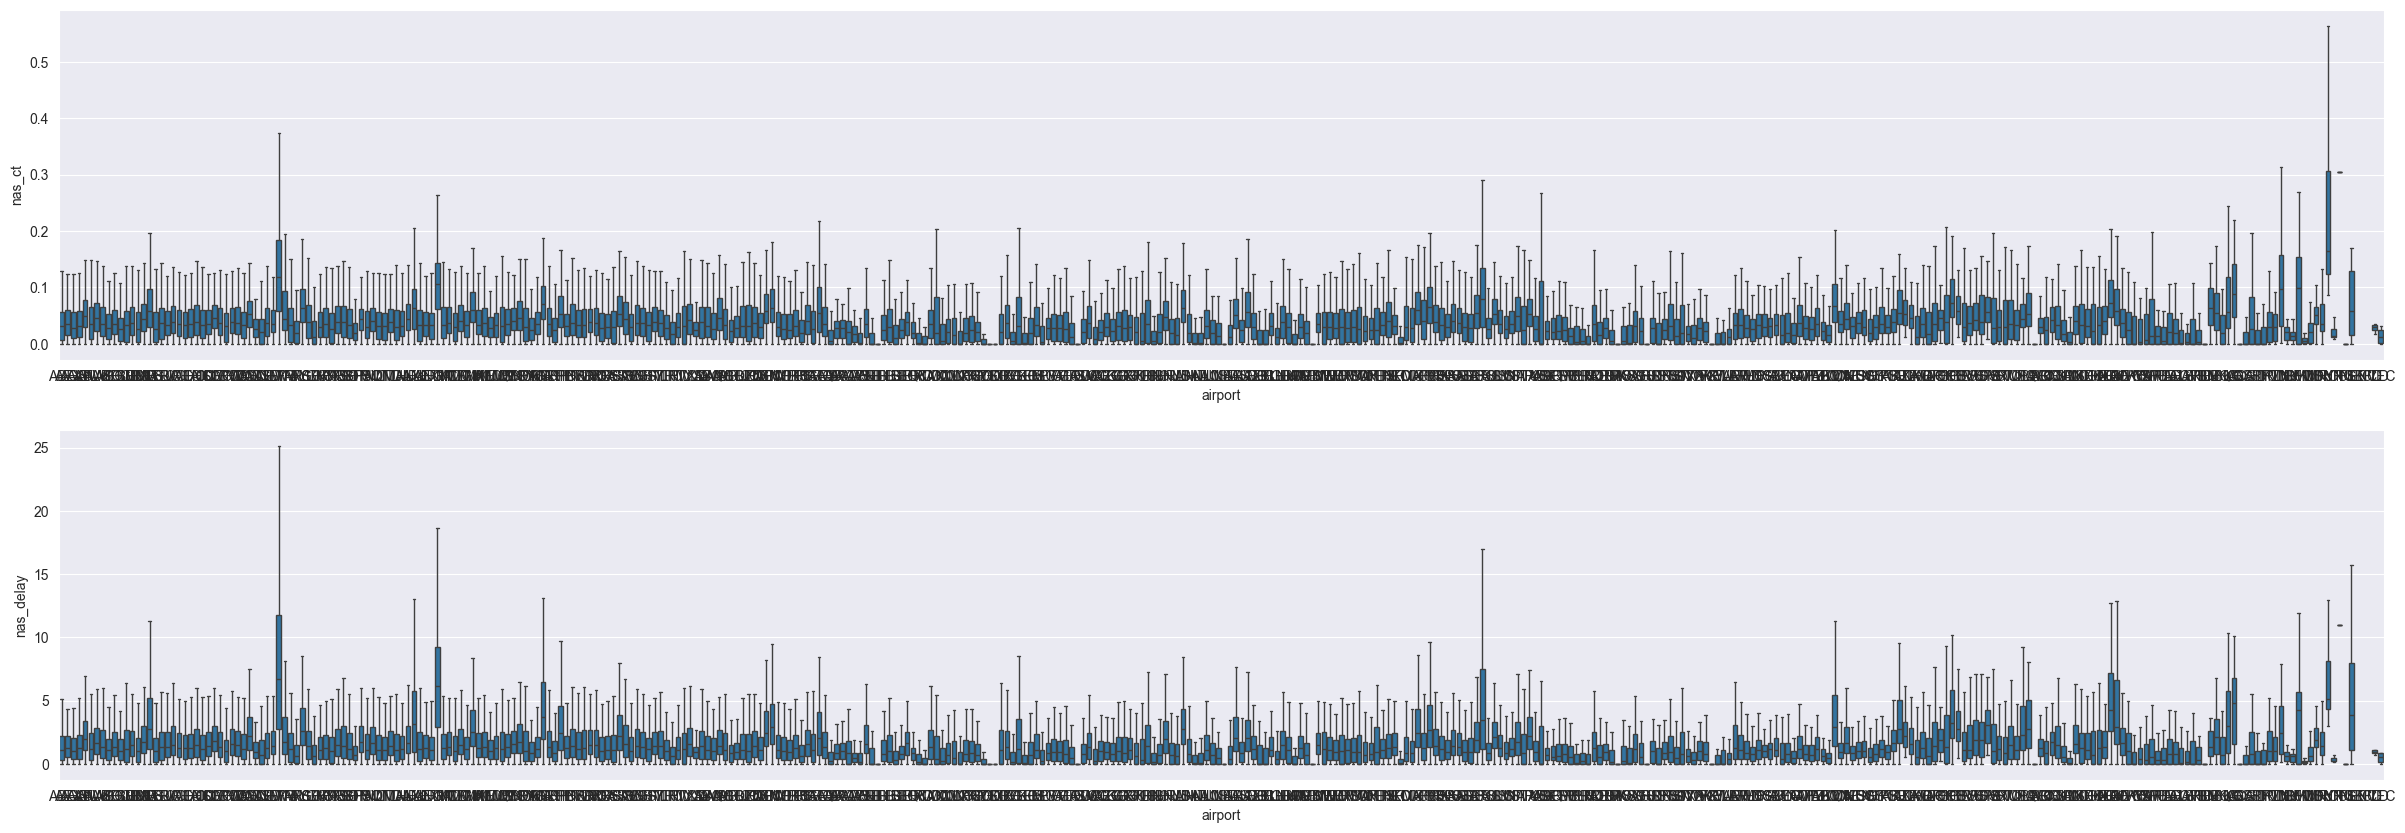

In [42]:
# variation of nas delay with airport 

label = 'nas'
_,axs = plt.subplots(2,1,figsize=[30,10])
sns.boxplot(data=dataImputed, x='airport',y=label+'_ct', ax=axs[0], showfliers=False)
sns.boxplot(data=dataImputed, x='airport',y=label+'_delay', ax=axs[1], showfliers=False)


<Axes: xlabel='airport', ylabel='late_aircraft_delay'>

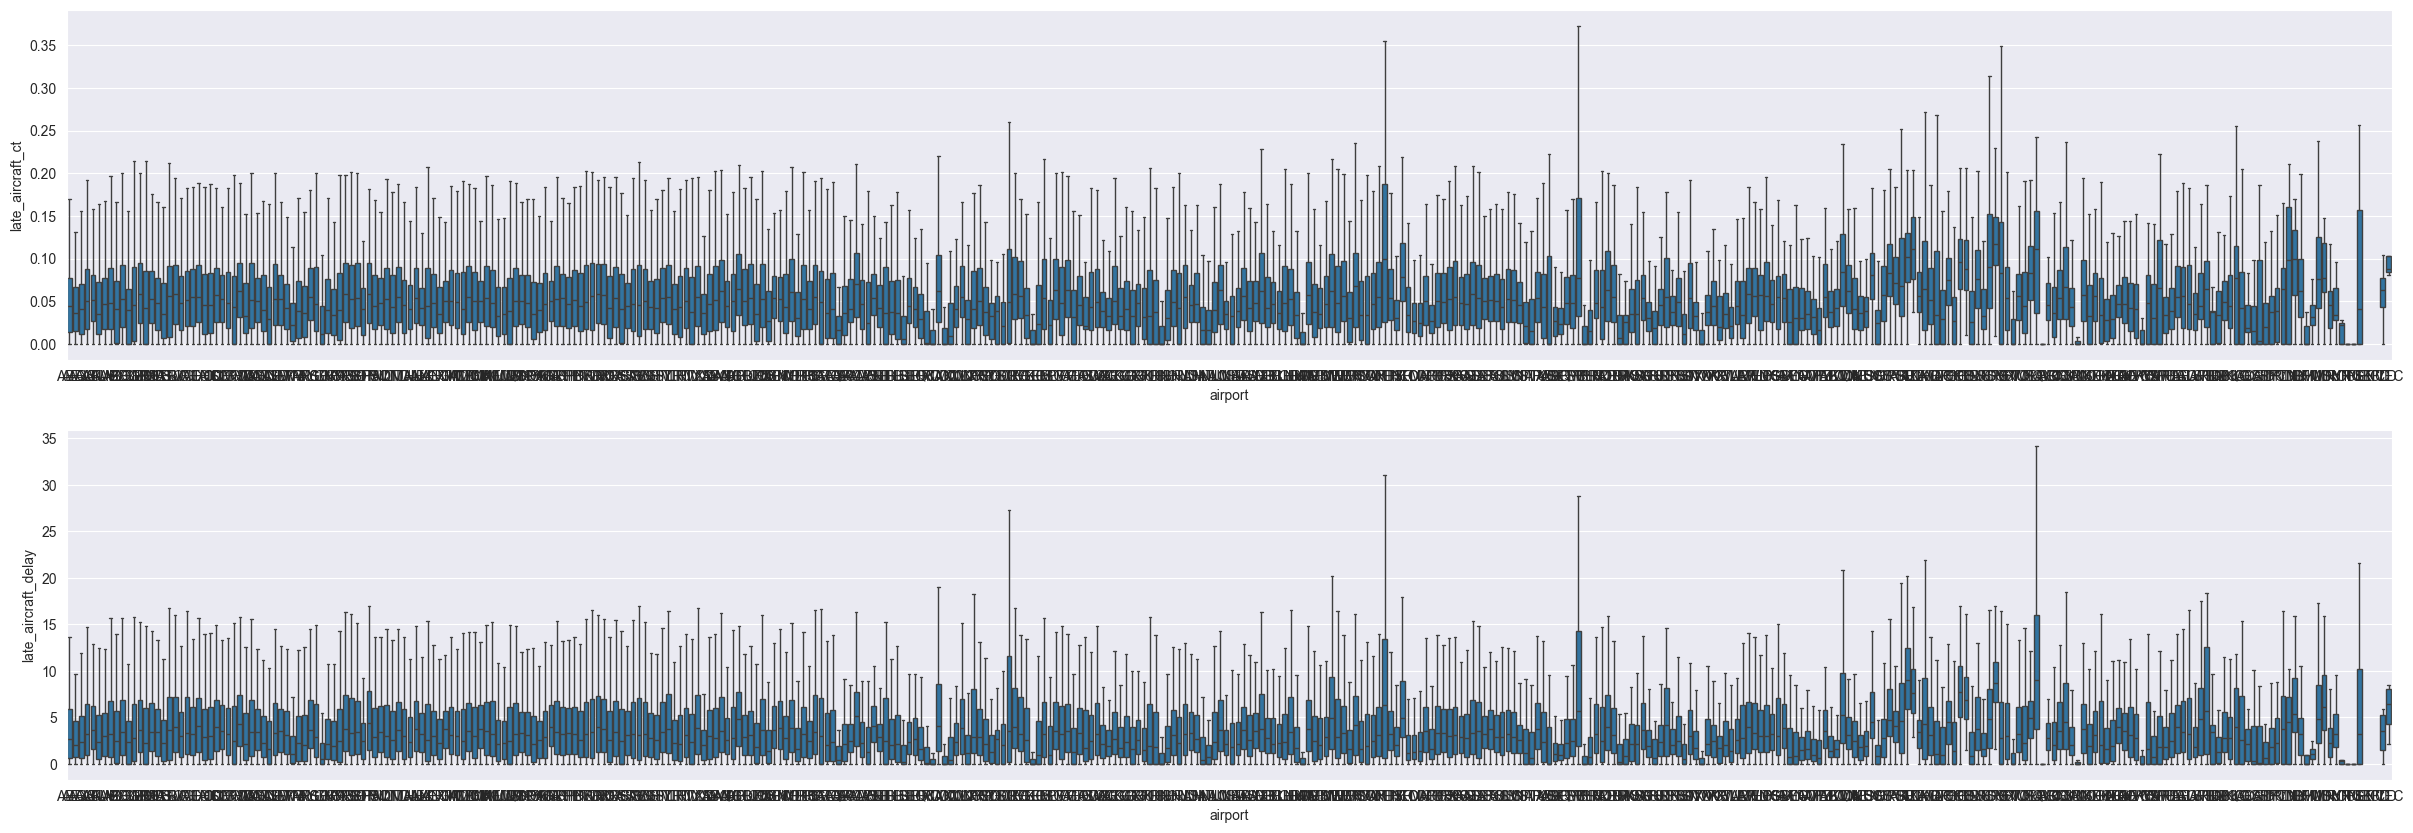

In [43]:
# variation of late aircraft delay with airport 

label = 'late_aircraft'
_,axs = plt.subplots(2,1,figsize=[30,10])
sns.boxplot(data=dataImputed, x='airport',y=label+'_ct', ax=axs[0], showfliers=False)
sns.boxplot(data=dataImputed, x='airport',y=label+'_delay', ax=axs[1], showfliers=False)

<Axes: xlabel='airport', ylabel='security_delay'>

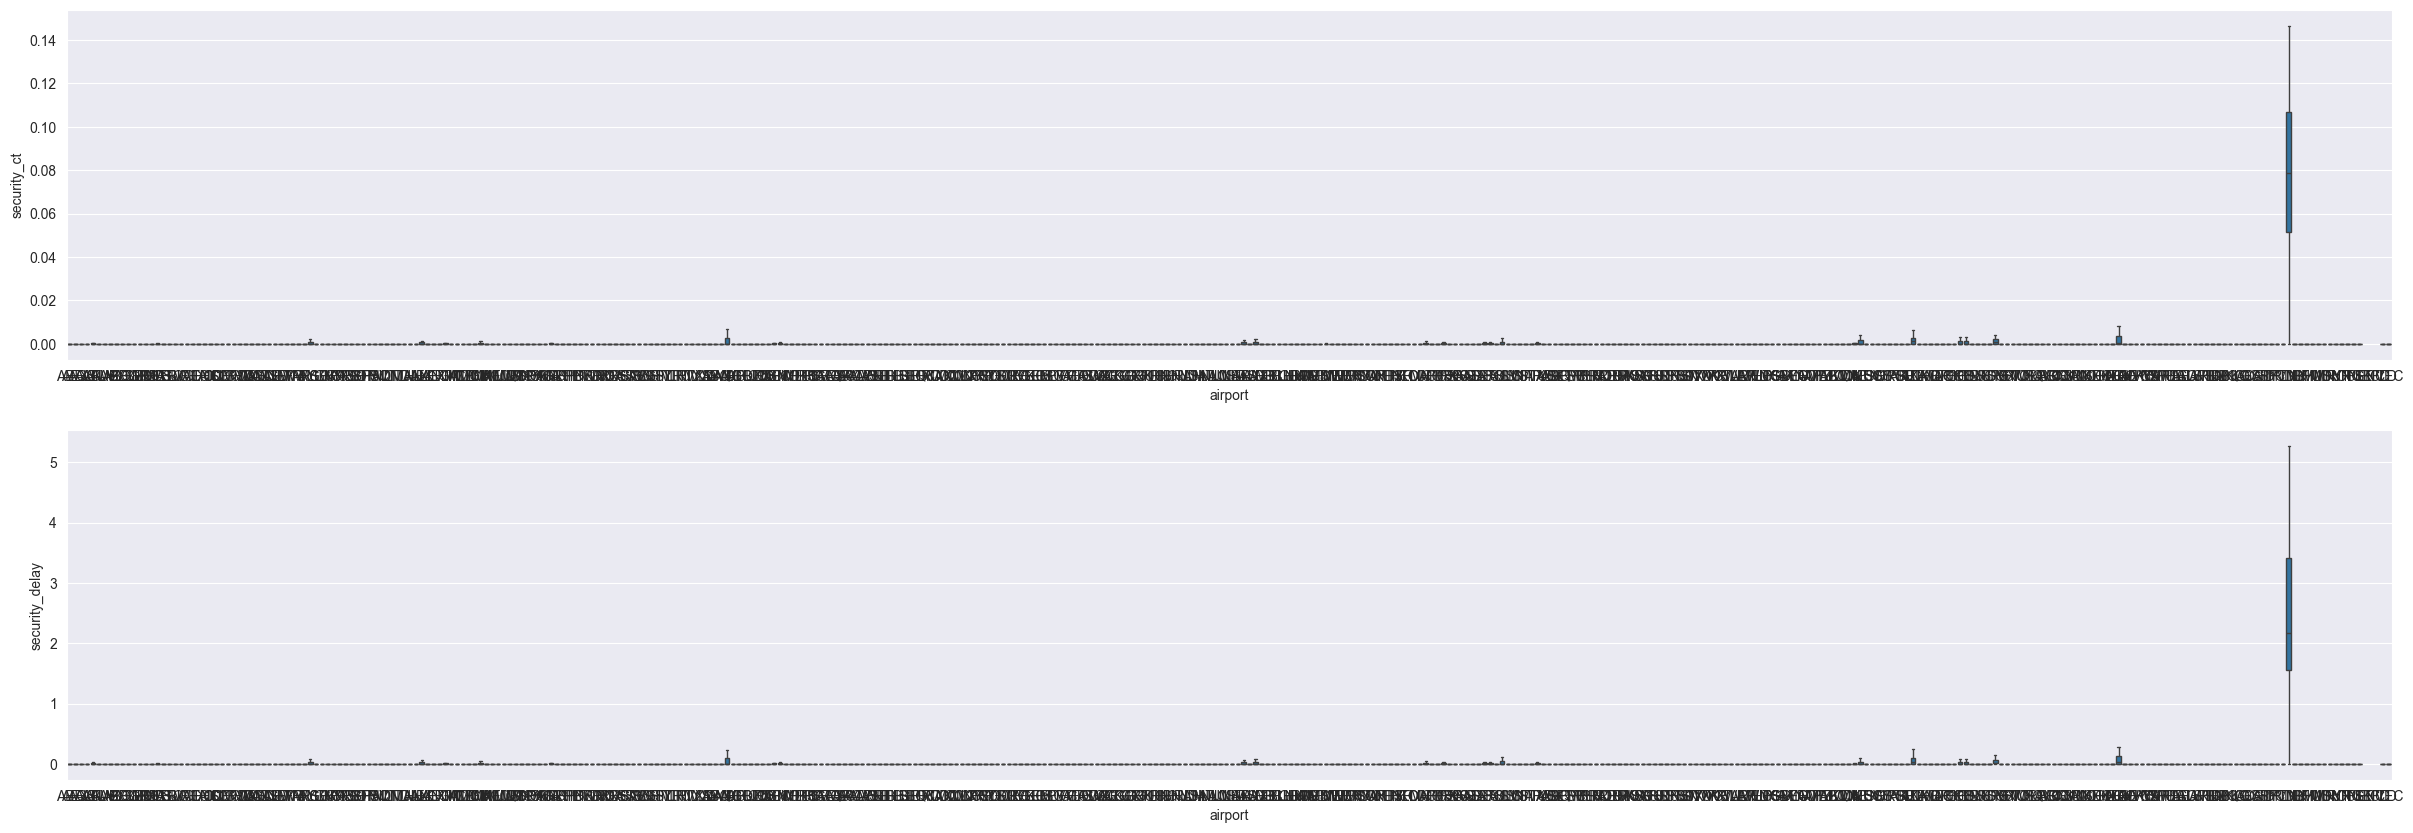

In [41]:
# variation of security delay with airport 

label = 'security'
_,axs = plt.subplots(2,1,figsize=[30,10])
sns.boxplot(data=dataImputed, x='airport',y=label+'_ct', ax=axs[0], showfliers=False)
sns.boxplot(data=dataImputed, x='airport',y=label+'_delay', ax=axs[1], showfliers=False)


<Axes: >

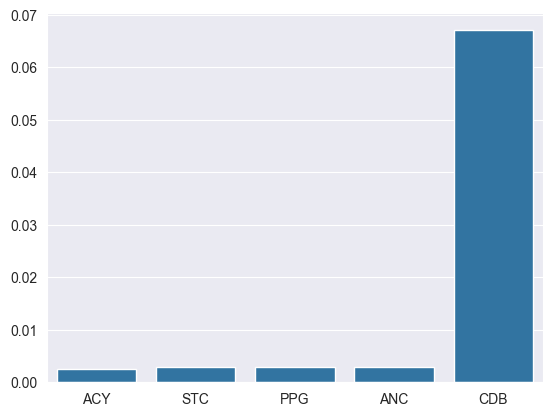

In [97]:
# finding airports with more security delays
airports = dataImputed.airport.unique()
dic = {}
for port in airports:
    # average security delays for airport
    portData = dataImputed.security_ct[dataNormalized.airport == port]
    dic[port] = sum(portData)/len(portData)

# displaying top 5 airports with most delay
sorted_dic = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1])}
sns.barplot(x=list(sorted_dic.keys())[-5:], y = list(sorted_dic.values())[-5:])


<Axes: xlabel='airport', ylabel='count'>

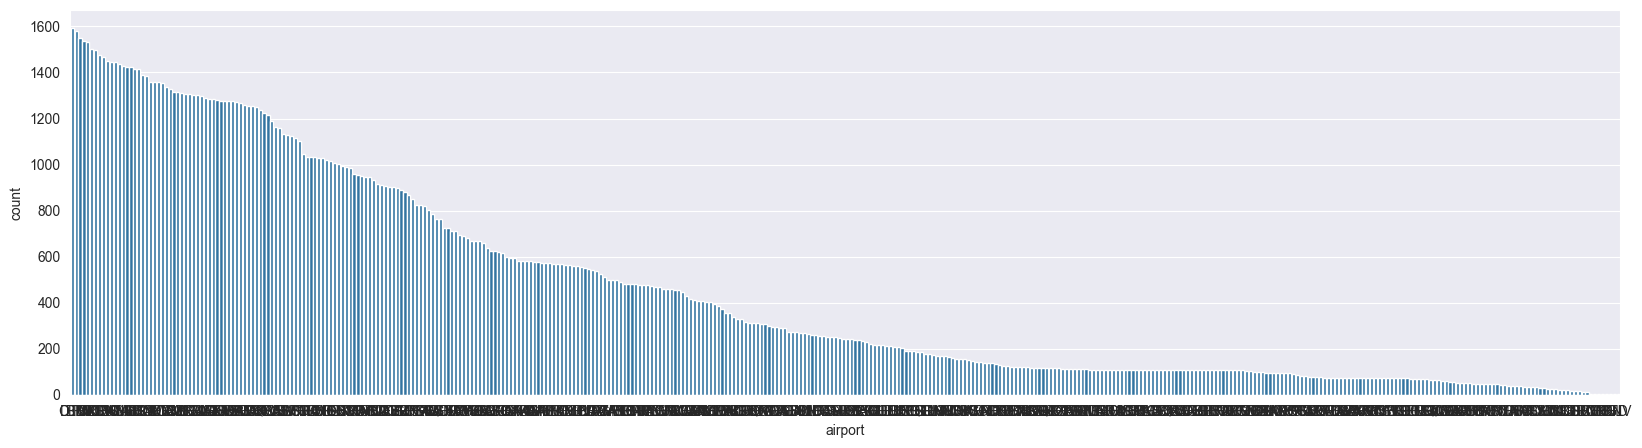

In [99]:
_,_ = plt.subplots(figsize=(20,5))
sns.barplot(dataImputed.airport.value_counts().nlargest(400))

# Feature Engineering 

In [8]:
# creating features from months with high and mid delay rate

high_month = dataImputed.month.isin([6,7,8]).astype(int)
mid_month = dataImputed.month.isin([1,2,12]).astype(int)

month_level = (np.where(
    dataImputed.month.isin([6,7,8]), 2, np.where(
        dataImputed.month.isin([1,2,12]),1,0
    )
))
is2020 = (dataImputed.year == 2020).astype(int)

<Axes: xlabel='carrier', ylabel='arr_del15'>

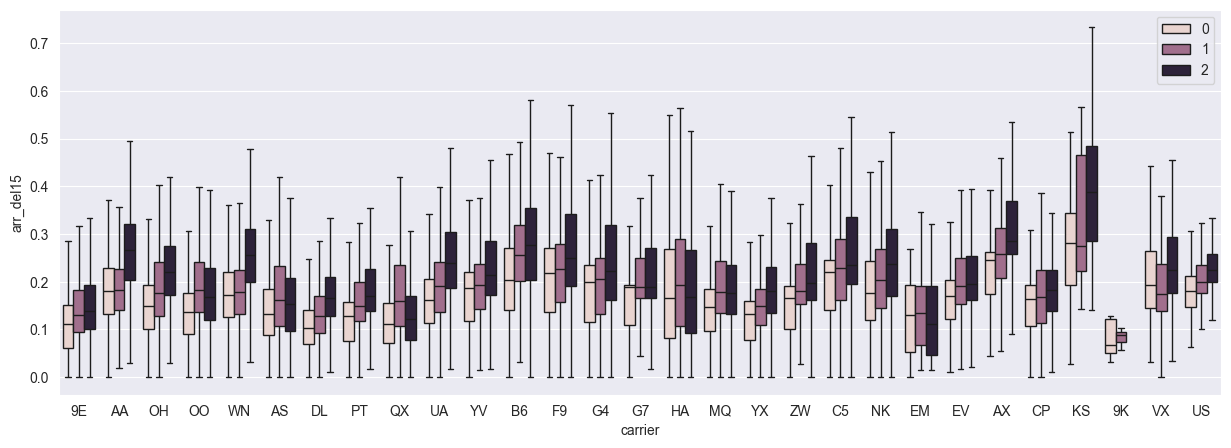

In [12]:
# influence of month category on delay 

_,_ = plt.subplots(figsize=(15,5))
sns.boxplot(data=dataImputed,x='carrier',y='arr_del15',hue=month_level,showfliers = False)

In [9]:
# label encoding of carrier and airport based on their rank of mean delay

carrier_rank = dataImputed.groupby('carrier')['arr_del15'].mean().rank()
carrier_encoding = dataImputed['carrier'].map(carrier_rank)

airport_rank = dataImputed.groupby('airport')['arr_del15'].mean().rank()
airport_encoding = dataImputed['airport'].map(airport_rank)

<Axes: xlabel='carrier', ylabel='arr_del15'>

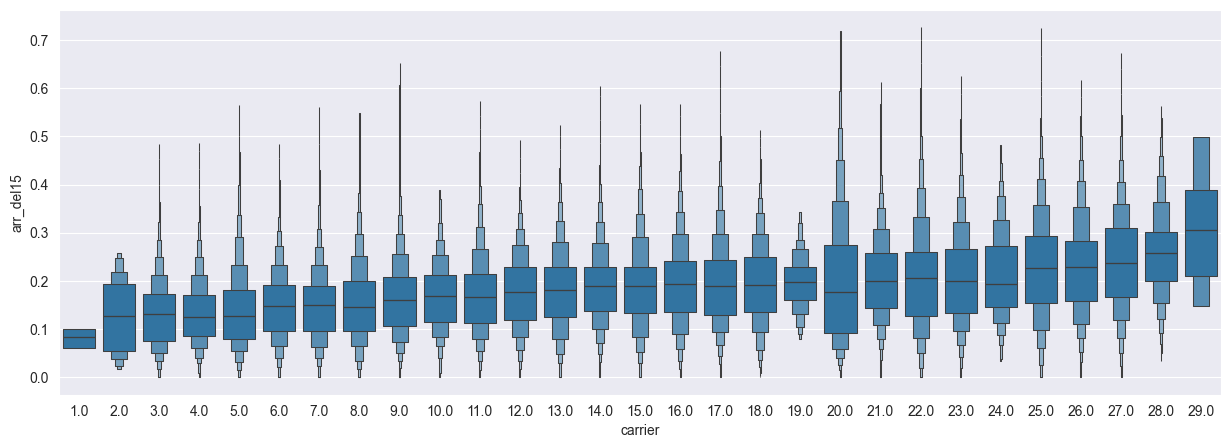

In [10]:
# rank of carrier vs arr_del15

_,_ = plt.subplots(figsize=(15,5))
sns.boxenplot(x=carrier_encoding,y=dataImputed.arr_del15,showfliers=False)

<Axes: xlabel='airport', ylabel='arr_del15'>

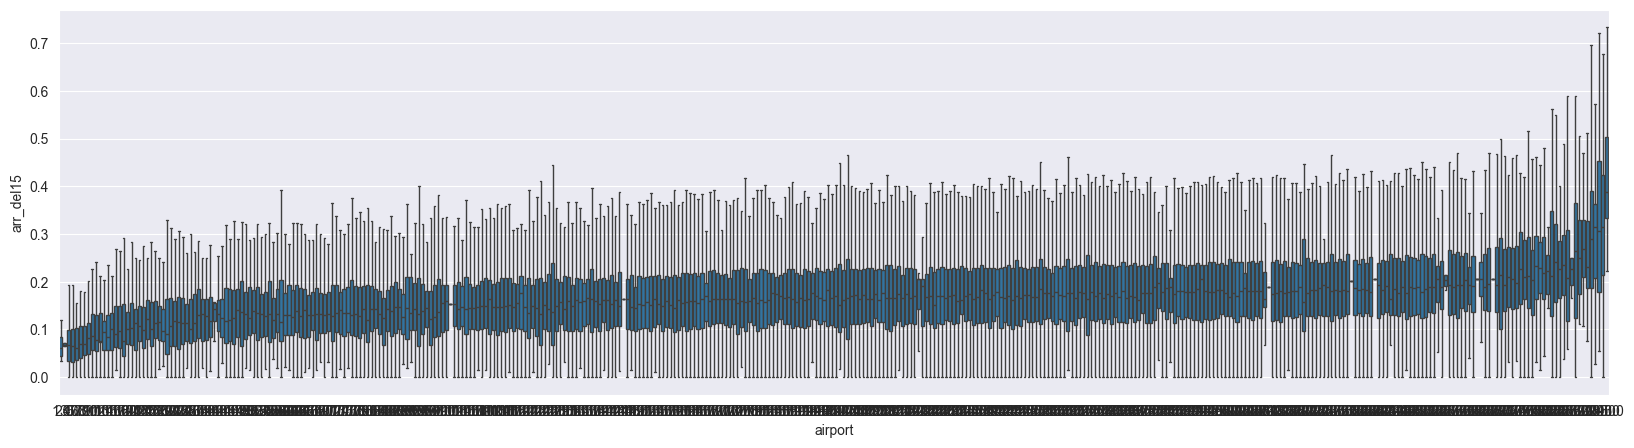

In [11]:
# rank of airport vs arr_del15

_,_ = plt.subplots(figsize=(20,5))
sns.boxplot(x=airport_encoding,y=dataImputed.arr_del15,showfliers=False)

<Axes: xlabel='arr_flights', ylabel='arr_del15'>

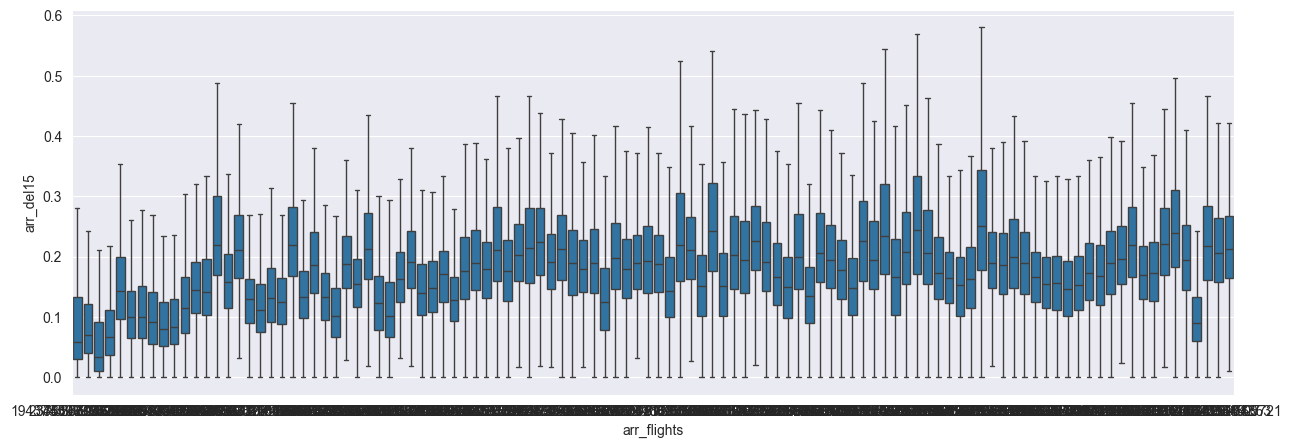

In [10]:
# calculating air trafic as total arrival flights for a month of an year

trafic = dataImputed.groupby(['month','year'])['arr_flights'].transform('sum')

# variation of delay with traffic
_,_ = plt.subplots(figsize=(15,5))
sns.boxplot(x=trafic,y=dataImputed.arr_del15,showfliers = False)

<Axes: xlabel='month', ylabel='arr_flights'>

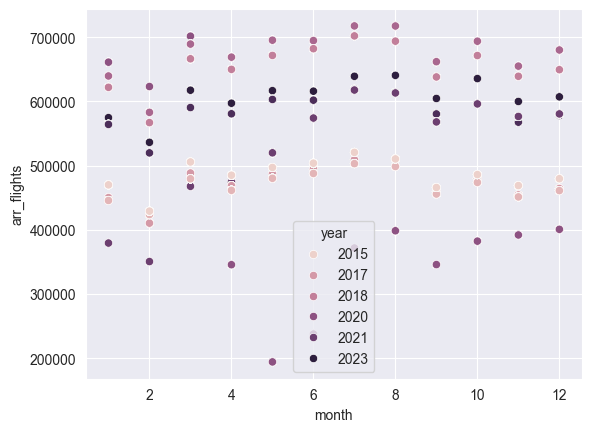

In [13]:
sns.scatterplot(x=dataImputed.month,y=trafic, hue=dataImputed.year)

In [11]:
# creating label for classification. delay per flight less than 15 is counted as delayed 

isDelayed = dataImputed.arr_delay >=15
isDelayed

0         False
1         False
2         False
3         False
4         False
          ...  
179333    False
179334     True
179335    False
179336    False
179337    False
Name: arr_delay, Length: 179338, dtype: bool

<Axes: xlabel='arr_delay', ylabel='Percent'>

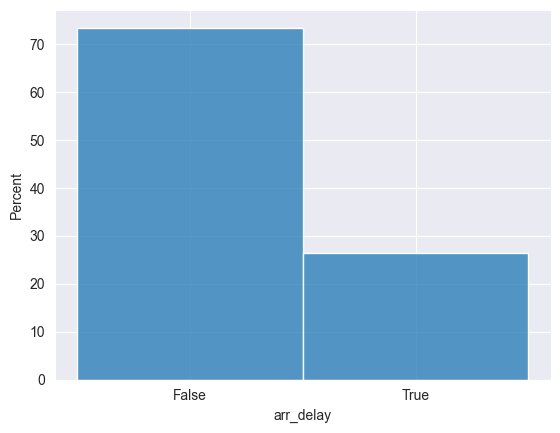

In [ ]:
# fraction delayed and not delayed 

sns.histplot(isDelayed.astype(dtype=str),stat='percent')

# Classification

In [15]:
# libraries 
from sklearn.preprocessing  import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score,recall_score,precision_score

from imblearn.over_sampling import SMOTE

import shap


/home/spectre/Desktop/work_cache/flight_delay/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# category encoding and feature scaling 

data_encoded = pd.get_dummies(dataImputed,columns=['carrier','airport'],drop_first=True)
data_encoded['high_month'] = high_month
data_encoded['mid_month'] = mid_month
data_encoded['is2020'] = is2020
data_encoded['airport'] = airport_encoding
data_encoded['carrier'] = carrier_encoding
data_encoded['trafic'] = trafic


scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_encoded)
data_scaled = pd.DataFrame(data_scaled,columns=data_encoded.columns)

label_df = isDelayed
feature_df = data_scaled.drop(data_scaled.loc[:,'arr_del15':'late_aircraft_delay'],axis=1)

In [ ]:
# # balancing dataset with smot

# print (f'label count before smote : {label_df.value_counts()}\n')
# smote=SMOTE(sampling_strategy='minority') 
# feature_df_balanced,label_df_balanced = smote.fit_resample(feature_df,label_df)
# print (f'label count before smote : {label_df_balanced.value_counts()}')

label count before smote : arr_delay
False    131831
True      47507
Name: count, dtype: int64

label count before smote : arr_delay
False    131831
True     131831
Name: count, dtype: int64


In [19]:
# spliting data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.2, random_state=111, stratify= label_df)
X_train, y_train = SMOTE(sampling_strategy='minority').fit_resample(X_train,y_train)

# X_train, X_test, y_train, y_test = train_test_split(feature_df_balanced, label_df_balanced, test_size=0.2, random_state=111, stratify= label_df_balanced)

In [52]:
# function to evaluate model 

def modelEval(model,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test):
    # model.fit(X_train,y_train)
    print (f'accuracy of training dataset : {accuracy_score(model.predict(X_train),y_train)}')
    pred = model.predict(X_test)
    print (f'accuracy of test dataset : {accuracy_score(pred,y_test)}')
    print (f'precision of test dataset : {precision_score(pred,y_test)}')
    print (f'recall of test dataset : {recall_score(pred,y_test)}')
    print (f'f1 score of test dataset : {f1_score(pred,y_test)}')
    print (f'roc-auc score of test dataset : {roc_auc_score(pred,y_test)}')
    cf_mat = confusion_matrix(model.predict(X_test),y_test)
    sns.heatmap(cf_mat/np.sum(cf_mat),annot=True, fmt='.2%', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("true")
    

accuracy of training dataset : 0.7110197253781279
accuracy of test dataset : 0.7066744730679156
precision of test dataset : 0.7167964639023363
recall of test dataset : 0.46520046444914964
f1 score of test dataset : 0.5642215134821688
roc-auc score of test dataset : 0.6692139788680007


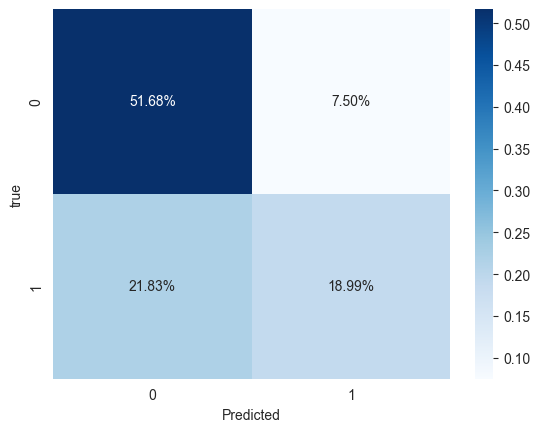

In [23]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
modelEval(log_reg,)

# with smote

accuracy of training dataset : 0.774231546664808
accuracy of test dataset : 0.7702966432474629
precision of test dataset : 0.3455062092191118
recall of test dataset : 0.619083537620215
f1 score of test dataset : 0.44349881796690305
roc-auc score of test dataset : 0.7078077593221309


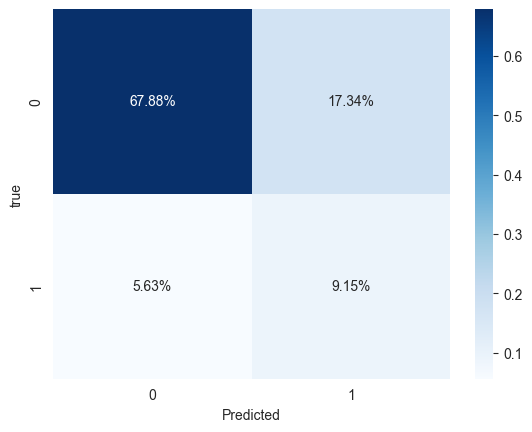

In [15]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
modelEval(log_reg,)

# with smote

accuracy of training dataset : 0.8963128180107339
accuracy of test dataset : 0.8033623285379725
precision of test dataset : 0.5393601347084824
recall of test dataset : 0.6569670555057044
f1 score of test dataset : 0.5923828237877825
roc-auc score of test dataset : 0.75050939442902


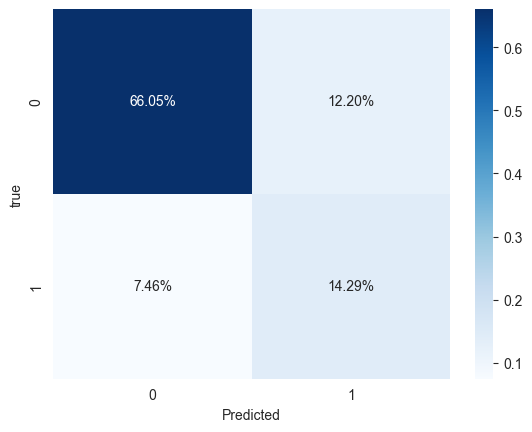

In [16]:
decision_tree = DecisionTreeClassifier(max_depth=20, random_state=31)
decision_tree.fit(X_train,y_train)
modelEval(decision_tree)

accuracy of training dataset : 0.9999790897051648
accuracy of test dataset : 0.8286773725883796
precision of test dataset : 0.5465165228372975
recall of test dataset : 0.7387964148527529
f1 score of test dataset : 0.6282741515939749
roc-auc score of test dataset : 0.7946903465435442


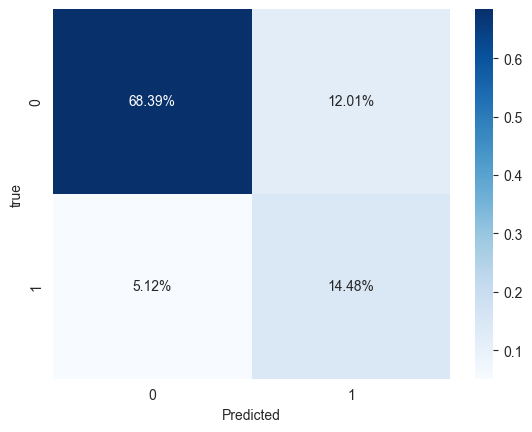

In [17]:
rfc = RandomForestClassifier(random_state=15)
rfc.fit(X_train,y_train)
modelEval(rfc)

accuracy of training dataset : 0.9445737784902767
accuracy of test dataset : 0.829179212668674
precision of test dataset : 0.5927173226689119
recall of test dataset : 0.7139054379515781
f1 score of test dataset : 0.6476913345983555
roc-auc score of test dataset : 0.7877937068595591


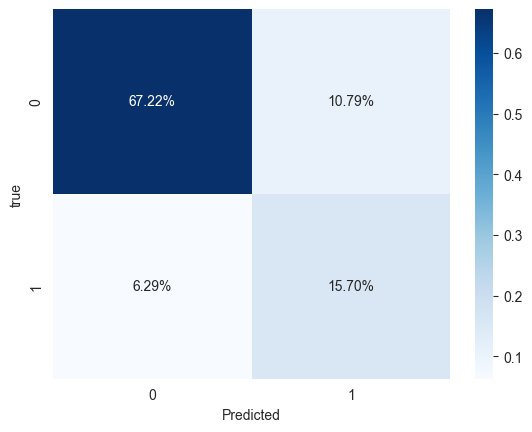

In [24]:
xgb_cls = xgb.XGBClassifier(random_state=20, max_depth = 20, reg_lambda=2)
xgb_cls.fit(X_train,y_train)
modelEval(xgb_cls)

# with smote

### Feature selection

In [31]:
pd.DataFrame({"columns":X_train.columns, "importance":xgb_cls.feature_importances_})

,columns,importance
0,year,0.007124
1,month,0.007033
2,arr_flights,0.001861
3,carrier_9K,0.000000
4,carrier_AA,0.003310
...,...,...
427,mid_month,0.034799
428,is2020,0.054538
429,airport,0.001694
430,carrier,0.011456


In [44]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
kbestF = SelectKBest(f_classif,k=100)
kbestMI = SelectKBest(mutual_info_classif,k=100)
X_train_Fbest = kbestF.fit_transform(X_train,y_train)
X_train_MIbest = kbestMI.fit_transform(X_train,y_train)

In [45]:
X_test_Fbest = kbestF.transform(X_test)
X_test_MIbest = kbestMI.transform(X_test)

In [42]:
feature_imp = pd.DataFrame({"columns":list(X_train.columns),
                            "importance":xgb_cls.feature_importances_})
treeFeatures = feature_imp.sort_values(by="importance", ascending=False)
X_train_treebest = X_train[treeFeatures['columns'][:100].to_numpy()]
X_test_treebest = X_test[treeFeatures['columns'][:100].to_numpy()]
# pd.concat([treeFeatures.reset_index(),MIBestScores.reset_index(),FBestScores.reset_index()],axis=1).head(50)
# plt.plot(np.log(feature_imp.sort_values(by="importance", ascending=False)["importance"].to_numpy()))

In [51]:
X_train_treebest.shape, y_test.shape

((210930, 100), (35868,))

accuracy of training dataset : 0.887403403972882
accuracy of test dataset : 0.8018568082970893
precision of test dataset : 0.5030519890549358
recall of test dataset : 0.6671318911374738
f1 score of test dataset : 0.5735885282294354
roc-auc score of test dataset : 0.751309735416488


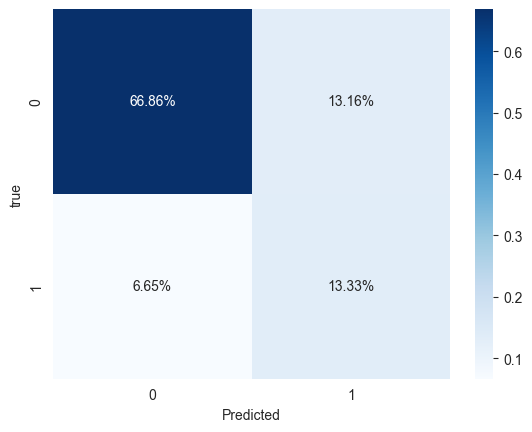

In [53]:
xgb_cls = xgb.XGBClassifier(random_state=20, max_depth = 20, reg_lambda=2)
xgb_cls.fit(X_train_treebest,y_train)
modelEval(xgb_cls,X_train_treebest,X_test_treebest)

accuracy of training dataset : 0.9501872659176029
accuracy of test dataset : 0.8092450094792015
precision of test dataset : 0.5588297200589349
recall of test dataset : 0.6670854271356784
f1 score of test dataset : 0.6081777574161036
roc-auc score of test dataset : 0.7584388007113106


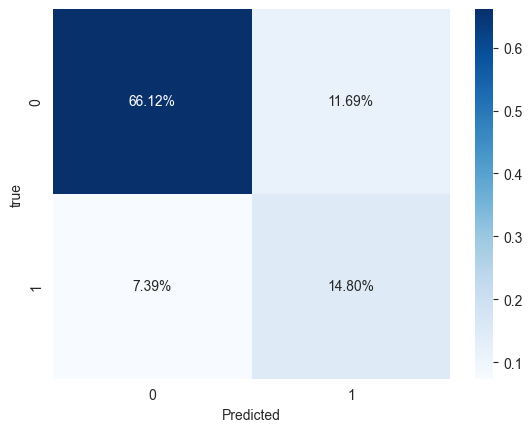

In [54]:
xgb_cls = xgb.XGBClassifier(random_state=20, max_depth = 20, reg_lambda=2)
xgb_cls.fit(X_train_Fbest,y_train)
modelEval(xgb_cls,X_train_Fbest,X_test_Fbest)

accuracy of training dataset : 0.9895889631631347
accuracy of test dataset : 0.8242444518791123
precision of test dataset : 0.5937697326878552
recall of test dataset : 0.6977491961414791
f1 score of test dataset : 0.641573800318399
roc-auc score of test dataset : 0.7794051574257176


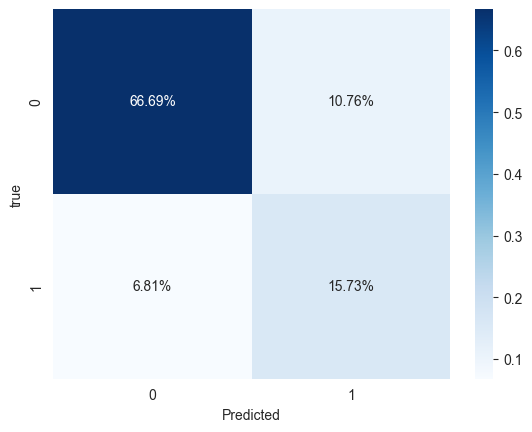

In [55]:
xgb_cls = xgb.XGBClassifier(random_state=20, max_depth = 20, reg_lambda=2)
xgb_cls.fit(X_train_MIbest,y_train)
modelEval(xgb_cls,X_train_MIbest,X_test_MIbest)

### fine tuning

In [99]:
# grid search for hyperparameter tuning 

def gridSearch(lrs,n_ests,m_depths, X_train, X_test):
    best = 0
    for lr in lrs:
        for n_est in n_ests:
            for md in m_depths:
                print (f'learning rate : {lr}, n_estimators : {n_est}, max_depth : {md}')
                xgb_cls = xgb.XGBClassifier(seed = 20, max_depth = md, reg_alpha=2, n_estimators=n_est, learning_rate=lr)
                xgb_cls.fit(X_train,y_train)
                f1 = f1_score(xgb_cls.predict(X_test),y_test)
                if (f1 >= best):
                    best = f1
                    print (f'\tf1 score  : {f1_score(xgb_cls.predict(X_test),y_test)}  (best)')
                else:
                    print (f'\tf1 score  : {f1_score(xgb_cls.predict(X_test),y_test)} ')
            


In [100]:
lrs = [0.4,0.3,0.2]
n_estimators = [50,100,150]
m_depths = [6,10,15]
gridSearch(lrs,n_estimators,m_depths, X_train_MIbest, X_test_MIbest)

learning rate : 0.4, n_estimators : 50, max_depth : 6
	f1 score  : 0.6047114252061249  (best)
learning rate : 0.4, n_estimators : 50, max_depth : 10
	f1 score  : 0.6318739054290718  (best)
learning rate : 0.4, n_estimators : 50, max_depth : 15
	f1 score  : 0.6431282346175963  (best)
learning rate : 0.4, n_estimators : 100, max_depth : 6
	f1 score  : 0.61751755325479 
learning rate : 0.4, n_estimators : 100, max_depth : 10
	f1 score  : 0.6458140610545791  (best)
learning rate : 0.4, n_estimators : 100, max_depth : 15
	f1 score  : 0.6447159990948178 
learning rate : 0.4, n_estimators : 150, max_depth : 6
	f1 score  : 0.6267204556241102 
learning rate : 0.4, n_estimators : 150, max_depth : 10
	f1 score  : 0.647464642980338  (best)
learning rate : 0.4, n_estimators : 150, max_depth : 15
	f1 score  : 0.643418688230009 
learning rate : 0.3, n_estimators : 50, max_depth : 6
	f1 score  : 0.604375623203707 
learning rate : 0.3, n_estimators : 50, max_depth : 10
	f1 score  : 0.6306274784231397 


In [102]:
lrs = [0.25,0.3,0.35]
n_estimators = [180,200,250]
m_depths = [6,10,15]
gridSearch(lrs,n_estimators,m_depths,X_train_MIbest,X_test_MIbest)

learning rate : 0.25, n_estimators : 180, max_depth : 6
	f1 score  : 0.6208296031035512  (best)
learning rate : 0.25, n_estimators : 180, max_depth : 10
	f1 score  : 0.6466235506613063  (best)
learning rate : 0.25, n_estimators : 180, max_depth : 15
	f1 score  : 0.6459930709376952 
learning rate : 0.25, n_estimators : 200, max_depth : 6
	f1 score  : 0.6251415628539071 
learning rate : 0.25, n_estimators : 200, max_depth : 10
	f1 score  : 0.6489565773411614  (best)
learning rate : 0.25, n_estimators : 200, max_depth : 15
	f1 score  : 0.6475317028985508 
learning rate : 0.25, n_estimators : 250, max_depth : 6
	f1 score  : 0.6320176221944395 
learning rate : 0.25, n_estimators : 250, max_depth : 10
	f1 score  : 0.6499566849552412  (best)
learning rate : 0.25, n_estimators : 250, max_depth : 15
	f1 score  : 0.644743510332789 
learning rate : 0.3, n_estimators : 180, max_depth : 6
	f1 score  : 0.6299821534800714 
learning rate : 0.3, n_estimators : 180, max_depth : 10
	f1 score  : 0.6519075

In [76]:
lrs = [0.2,0.3,0.4]
n_estimators = [150,200,250]
gridSearch(lrs,n_estimators,X_train_MIbest,X_test_MIbest)

learning rate : 0.2, n_estimators : 150
	f1 score  : 0.6431842197957027  (best)
learning rate : 0.2, n_estimators : 200
	f1 score  : 0.6438693055392903  (best)
learning rate : 0.2, n_estimators : 250
	f1 score  : 0.6497355727320276  (best)
learning rate : 0.3, n_estimators : 150
	f1 score  : 0.647410937409194 
learning rate : 0.3, n_estimators : 200
	f1 score  : 0.6535396697078184  (best)
learning rate : 0.3, n_estimators : 250
	f1 score  : 0.6515613318764736 
learning rate : 0.4, n_estimators : 150
	f1 score  : 0.647464642980338 
learning rate : 0.4, n_estimators : 200
	f1 score  : 0.6491048010035352 
learning rate : 0.4, n_estimators : 250
	f1 score  : 0.6445896052257881 


In [67]:
lrs = [0.2,0.3,0.4]
n_estimators = [150,200,250]
gridSearch(lrs,n_estimators,X_train_MIbest,X_test_MIbest)

learning rate : 0.2, n_estimators : 150
	f1 score  : 0.6431842197957027  (best)
learning rate : 0.2, n_estimators : 200
	f1 score  : 0.6438693055392903  (best)
learning rate : 0.2, n_estimators : 250
	f1 score  : 0.6497355727320276  (best)
learning rate : 0.3, n_estimators : 150
	f1 score  : 0.647410937409194 
learning rate : 0.3, n_estimators : 200
	f1 score  : 0.6535396697078184  (best)
learning rate : 0.3, n_estimators : 250
	f1 score  : 0.6515613318764736 
learning rate : 0.4, n_estimators : 150
	f1 score  : 0.647464642980338 
learning rate : 0.4, n_estimators : 200
	f1 score  : 0.6491048010035352 
learning rate : 0.4, n_estimators : 250
	f1 score  : 0.6445896052257881 


accuracy of training dataset : 0.9360640970938225
accuracy of test dataset : 0.8327199732351958
precision of test dataset : 0.5955588297200589
recall of test dataset : 0.7240276356192425
f1 score of test dataset : 0.6535396697078184
roc-auc score of test dataset : 0.7935160279907134


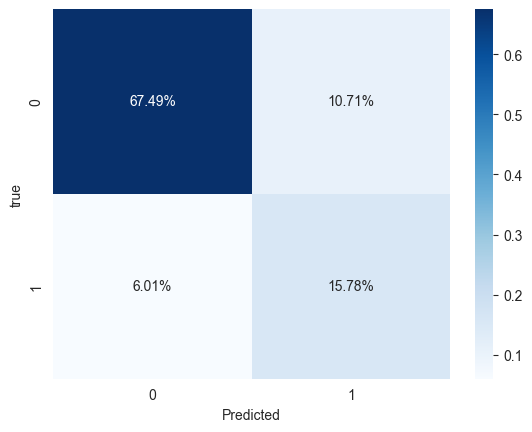

In [77]:
xgb_cls = xgb.XGBClassifier(seed = 20, max_depth = 10, reg_alpha=2, n_estimators=200, learning_rate=0.3)
xgb_cls.fit(X_train_MIbest,y_train)
modelEval(xgb_cls,X_train_MIbest,X_test_MIbest)

In [ ]:
# ploting shap values 
# X_sample = X_test.sample(100)
explainer = shap.TreeExplainer(xgb_cls_best,X_test,approximate=True)

shap_val = explainer.shap_values(X_test)

shap.summary_plot(shap_val, X_test, plot_type='violin')
plt.show()

  9%|==                  | 4717/52733 [05:54<60:03]       

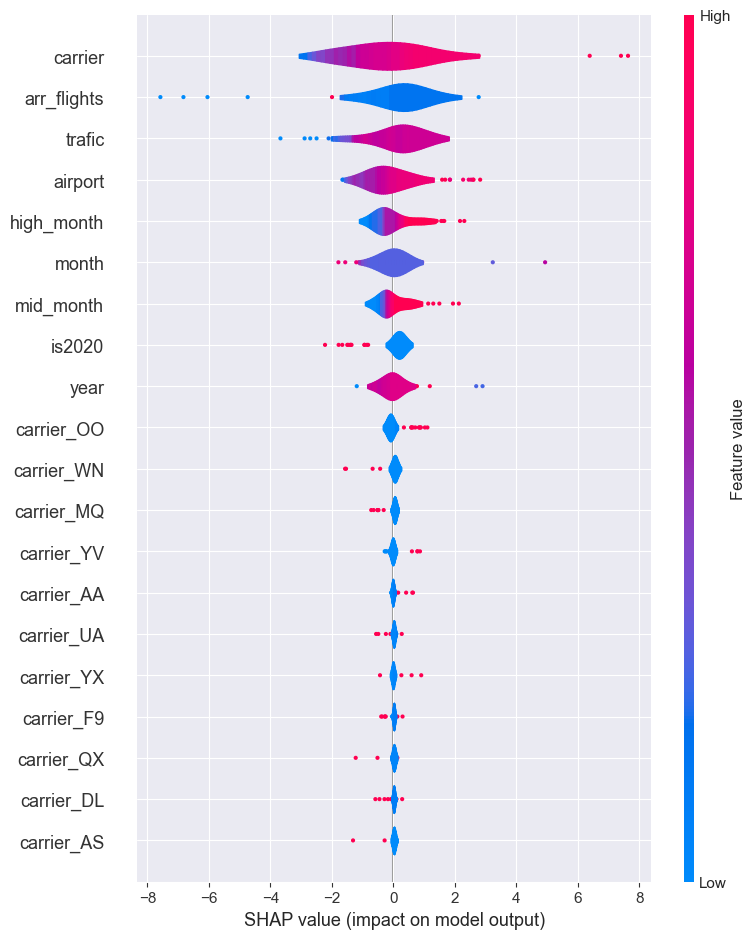

In [37]:
# ploting shap values 
X_sample = X_test.sample(100)
explainer = shap.TreeExplainer(xgb_cls_best,X_sample,approximate=True)

shap_val = explainer.shap_values(X_sample)

shap.summary_plot(shap_val, X_sample, plot_type='violin')
plt.show()

# Regression

In [12]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score

from sklearn.metrics import root_mean_squared_error, mean_absolute_error

In [64]:
# category encoding and feature scaling 

data_encoded = pd.get_dummies(dataImputed,columns=['carrier'],drop_first=True)
data_encoded['high_month'] = high_month
data_encoded['mid_month'] = mid_month
data_encoded['is2020'] = is2020
data_encoded['airport'] = airport_encoding
data_encoded['carrier'] = carrier_encoding
data_encoded['trafic'] = trafic

# label_df = data_encoded.loc[:,['arr_delay']]
# feature_df = data_encoded.drop(data_encoded.loc[:,'arr_del15':'late_aircraft_delay'],axis=1)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_encoded)
data_scaled = pd.DataFrame(data_scaled,columns=data_encoded.columns)

label_df = data_scaled.loc[:,['arr_delay']]
feature_df = data_scaled.drop(data_scaled.loc[:,'arr_del15':'late_aircraft_delay'],axis=1)

In [105]:
# getting cross validation score using stratified k-fold validation

def cross_validation_reg(model, X, Y, fold = 5):
    scores = cross_val_score(
      model, X,
      Y,
      scoring="neg_mean_squared_error",
      verbose=2, cv=fold)
    rmse_scores = np.sqrt(-scores)
    print("RMSEs:", rmse_scores)
    print("Mean:", rmse_scores.mean())
    print("StandardDeviation:", rmse_scores.std())

In [34]:
#testing difference models with 5 fold validation

print("----:\t Linear Regression \t:----")
lin_reg = LinearRegression()
cross_validation_reg(lin_reg, feature_df, label_df)
print("")
print("----:\t lasso Regression \t:----")
lasso_reg = Lasso()
cross_validation_reg(lasso_reg, feature_df, label_df)
print("")
print("----:\t ridge Regression \t:----")
ridge_reg = Ridge()
cross_validation_reg(ridge_reg, feature_df, label_df)
print("")
print("----:\t Decision Tree Regression \t:----")
tree_reg = DecisionTreeRegressor()
cross_validation_reg(tree_reg, feature_df, label_df)
print("")
print("----:\t xgboost Regression Model \t:----")
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror',seed = 123)
cross_validation_reg(xgb_reg, feature_df, label_df)

----:	 Linear Regression 	:----
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
RMSEs: [1.0312801  0.93409322 0.84018968 0.90193281 0.75644676]
Mean: 0.8927885148734436
StandardDeviation: 0.09200579294744515

----:	 lasso Regression 	:----
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
RMSEs: [1.13322871 1.03980313 1.01642292 0.99804326 0.81173792]
Mean: 0.9998471883758973
StandardDeviation: 0.10492874915488606

----:	 ridge Regression 	:----


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
RMSEs: [1.03128012 0.93409307 0.84019003 0.90193261 0.75644571]
Mean: 0.8927883101780706
StandardDeviation: 0.09200605000056673

----:	 Decision Tree Regression 	:----


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   1.0s
RMSEs: [1.37776061 1.28739109 1.177713   1.20760058 1.0440843 ]
Mean: 1.2189099123622997
StandardDeviation: 0.1116353861073437

----:	 xgboost Regression Model 	:----


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.0s finished


[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
RMSEs: [1.00841912 0.91802511 0.87152014 0.88739908 0.83800404]
Mean: 0.9046734994428343
StandardDeviation: 0.05793752887445303


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished


In [ ]:
# cross validation with 10 folds for linear regression and xgb

print("----:\t Linear Regression Model Cross Validation \t:----")
lin_reg = LinearRegression()
cross_validation_reg(lin_reg, feature_df, label_df,fold=10)
print("")
print("----:\t xgboost Regression Model Cross Validation \t:----")
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators = 20, seed = 123, max_depth=5)
cross_validation_reg(xgb_reg, feature_df, label_df,fold=10)

----:	 Linear Regression Model Cross Validation 	:----
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.4s
RMSEs: [1.0161082  0.94985565 0.86352769 1.03713823 0.8008773  0.88487371
 0.88829035 0.86624282 0.80948433 0.7481494 ]
Mean: 0.8864547

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.4s finished


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s
RMSEs: [0.98915803 0.95734444 0.86463966 1.00741534 0.92905674 0.85525538
 0.86962863 0.84261012 0.7808047  0.73103833]
Mean: 0.8826951364503589
StandardDeviation: 0.08417204143647813


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished


In [17]:
# spliting data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.2, random_state=42)

In [65]:
# linear regression fitting 

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
print (f'RMSE for training set : {root_mean_squared_error(lin_reg.predict(X_train),y_train)}')
print (f'MAE for training set : {mean_absolute_error(lin_reg.predict(X_train),y_train)}')
print (f'RMSE for testing set : {root_mean_squared_error(lin_reg.predict(X_test),y_test)}')
print (f'MAE for testing set : {mean_absolute_error(lin_reg.predict(X_test),y_test)}')
print (f'R squared : {lin_reg.score(X_train,y_train)}')

RMSE for training set : 0.8793518656800211
MAE for training set : 0.5967704221820945
RMSE for testing set : 0.881974272649514
MAE for testing set : 0.598671781901966
R squared : 0.2264816409903525


In [ ]:
xgb_reg_best = xgb.XGBRegressor(objective ='reg:squarederror', seed = 123, n_estimators=100,learning_rate=0.3)
xgb_reg_best.fit(X_train,y_train)
print (f'RMSE for training set : {root_mean_squared_error(xgb_reg_best.predict(X_train),y_train)}')
print (f'MAE for training set : {mean_absolute_error(xgb_reg_best.predict(X_train),y_train)}')
print (f'RMSE for testing set : {root_mean_squared_error(xgb_reg_best.predict(X_test),y_test)}')
print (f'MAE for testing set : {mean_absolute_error(xgb_reg_best.predict(X_test),y_test)}')
print (f'R squared : {xgb_reg_best.score(X_train,y_train)}')

RMSE for training set : 0.7298277020454407
MAE for training set : 0.4678962826728821
RMSE for testing set : 0.7788121700286865
MAE for testing set : 0.49040693044662476
R squared : 0.46717339754104614


In [40]:
# grid search for hyperparameter tuning 

def gridSearch(lrs,n_ests):
    best = 999
    for lr in lrs:
        for n_est in n_ests:
            print (f'learning rate : {lr}, n_estimators : {n_est}')
            xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', seed = 123, n_estimators=n_est, learning_rate=lr)
            xgb_reg.fit(X_train,y_train)
            RMSE = root_mean_squared_error(xgb_reg.predict(X_test),y_test)
            if (RMSE < best):
                best = RMSE
                print (f'\tRMSE  : {root_mean_squared_error(xgb_reg.predict(X_test),y_test)}  (best)')
            else:
                print (f'\tRMSE  : {root_mean_squared_error(xgb_reg.predict(X_test),y_test)} ')
            


In [128]:
learning_rates = [0.3,0.1,0.05]
n_estimators = [100,500,1000,5000]

gridSearch(learning_rates,n_estimators)

learning rate : 0.3, n_estimators : 100
	RMSE  : 0.7449901103973389  (best)
learning rate : 0.3, n_estimators : 500
	RMSE  : 0.7234574556350708  (best)
learning rate : 0.3, n_estimators : 1000
	RMSE  : 0.7259256839752197 
learning rate : 0.3, n_estimators : 5000
	RMSE  : 0.7625177502632141 
learning rate : 0.1, n_estimators : 100
	RMSE  : 0.7729727029800415 
learning rate : 0.1, n_estimators : 500
	RMSE  : 0.7349361777305603 
learning rate : 0.1, n_estimators : 1000
	RMSE  : 0.7226026058197021  (best)
learning rate : 0.1, n_estimators : 5000
	RMSE  : 0.7262182831764221 
learning rate : 0.05, n_estimators : 100
	RMSE  : 0.7948105335235596 
learning rate : 0.05, n_estimators : 500
	RMSE  : 0.7519327998161316 
learning rate : 0.05, n_estimators : 1000
	RMSE  : 0.7347257137298584 
learning rate : 0.05, n_estimators : 5000
	RMSE  : 0.718136191368103  (best)


In [130]:
learning_rates = [0.1,0.05,0.03]
n_estimators = [4000,5000,6000]

gridSearch(learning_rates,n_estimators)

learning rate : 0.1, n_estimators : 4000
	RMSE  : 0.7226228713989258  (best)
learning rate : 0.1, n_estimators : 5000
	RMSE  : 0.7262182831764221 
learning rate : 0.1, n_estimators : 6000
	RMSE  : 0.7294612526893616 
learning rate : 0.05, n_estimators : 4000
	RMSE  : 0.7177634239196777  (best)
learning rate : 0.05, n_estimators : 5000
	RMSE  : 0.718136191368103 
learning rate : 0.05, n_estimators : 6000
	RMSE  : 0.7192583680152893 
learning rate : 0.03, n_estimators : 4000
	RMSE  : 0.7232272624969482 
learning rate : 0.03, n_estimators : 5000
	RMSE  : 0.7206223011016846 
learning rate : 0.03, n_estimators : 6000
	RMSE  : 0.7195985317230225 


In [132]:
learning_rates = [0.07,0.05,0.03]
n_estimators = [3500,4000,4500]

gridSearch(learning_rates,n_estimators)

learning rate : 0.07, n_estimators : 3500
	RMSE  : 0.7197086811065674  (best)
learning rate : 0.07, n_estimators : 4000
	RMSE  : 0.720439076423645 
learning rate : 0.07, n_estimators : 4500
	RMSE  : 0.7209452986717224 
learning rate : 0.05, n_estimators : 3500
	RMSE  : 0.7179387807846069  (best)
learning rate : 0.05, n_estimators : 4000
	RMSE  : 0.7177634239196777  (best)
learning rate : 0.05, n_estimators : 4500
	RMSE  : 0.7179558277130127 
learning rate : 0.03, n_estimators : 3500
	RMSE  : 0.7246147990226746 
learning rate : 0.03, n_estimators : 4000
	RMSE  : 0.7232272624969482 
learning rate : 0.03, n_estimators : 4500
	RMSE  : 0.7217626571655273 


In [45]:
xgb_reg_best = xgb.XGBRegressor(objective ='reg:squarederror', seed = 123, n_estimators=4000,learning_rate=0.05)
xgb_reg_best.fit(X_train,y_train)
print (f'RMSE for training set : {root_mean_squared_error(xgb_reg_best.predict(X_train),y_train)}')
print (f'MAE for training set : {mean_absolute_error(xgb_reg_best.predict(X_train),y_train)}')
print (f'RMSE for testing set : {root_mean_squared_error(xgb_reg_best.predict(X_test),y_test)}')
print (f'MAE for testing set : {mean_absolute_error(xgb_reg_best.predict(X_test),y_test)}')
print (f'R squared : {xgb_reg_best.score(X_train,y_train)}')

RMSE for training set : 0.5728569030761719
MAE for training set : 0.3744417726993561
RMSE for testing set : 0.7590894103050232
MAE for testing set : 0.468217670917511
R squared : 0.6717251539230347


### Shap

In [47]:
import shap


In [223]:
# training model for shap interpretations

xg = xgb.XGBRegressor(objective ='reg:squarederror', seed = 123,n_estimators = 4000, learning_rate=0.05)
xg.fit(X_train,y_train.iloc[:,1])

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


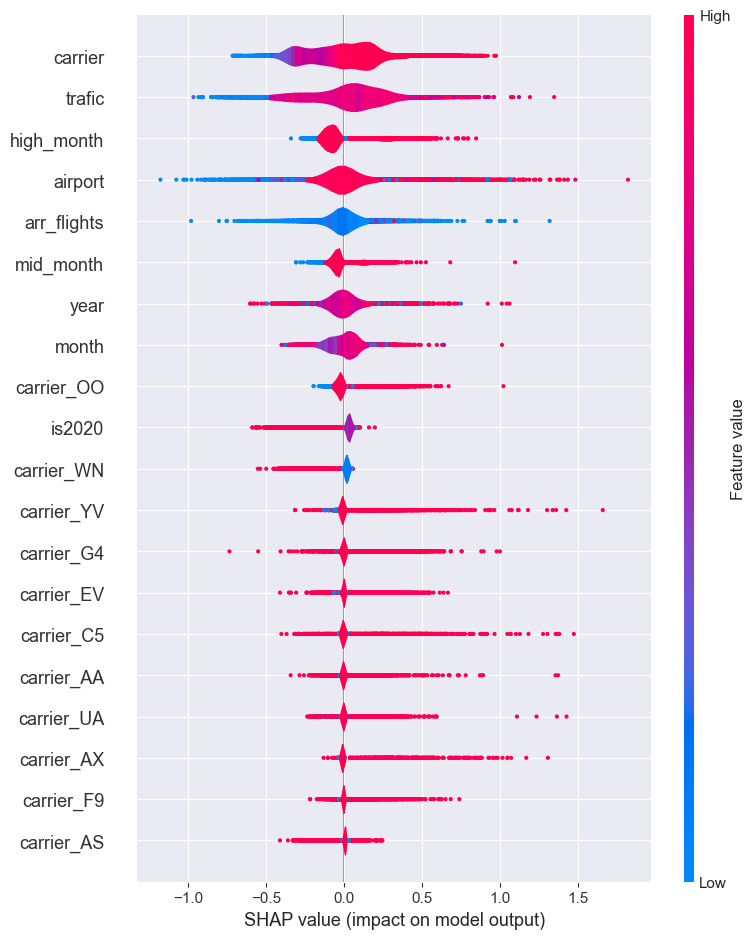

In [48]:
# ploting shap values 

explainer = shap.TreeExplainer(xgb_reg_best)
shap_val = explainer.shap_values(X_test)
shap.summary_plot(shap_val, X_test,plot_type='violin')
plt.show()

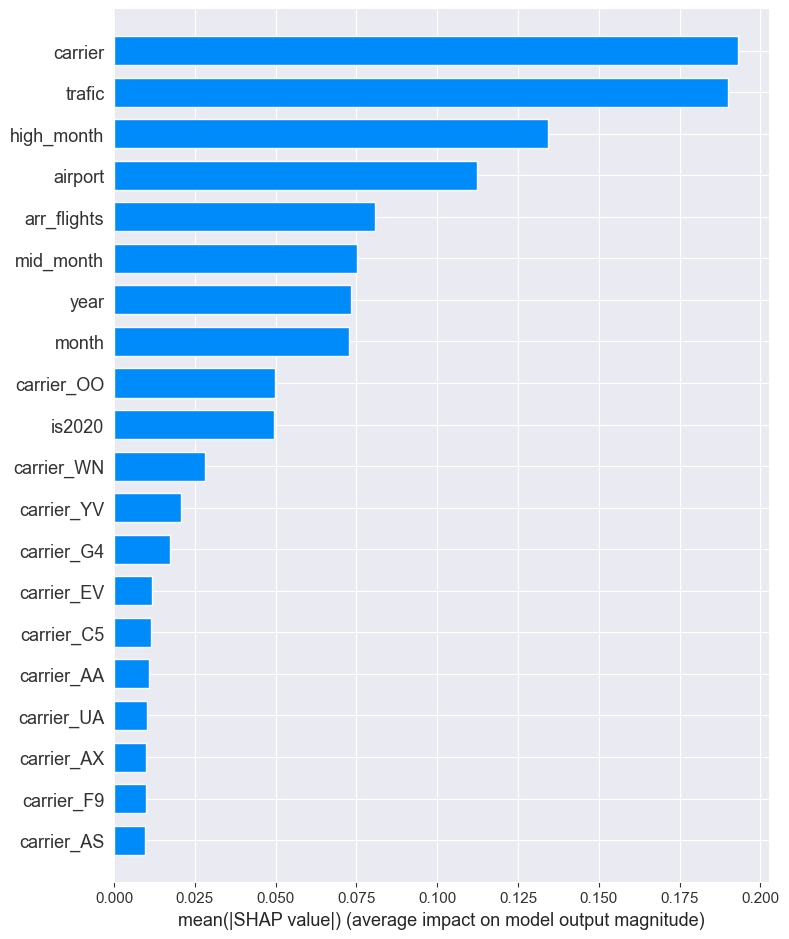

In [49]:
shap.summary_plot(shap_val, X_test,plot_type='bar')
plt.show()